In [1]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

2021-10-27 18:01:53.853312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-27 18:01:53.853667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path =r'../data/datasets_by_whale/'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    df = pd.read_csv(filename).drop(columns=["Unnamed: 0", "individual-local-identifier", "year", "month"])
    if df.shape > (40,):
        dfs.append(df)

In [3]:
df

,location-long,location-lat
0,-96.698,8.794
1,-96.577,8.746
2,-96.623,9.087
3,-96.712,9.110
4,-96.810,8.989
...,...,...
316,-115.027,26.702
317,-115.930,26.972
318,-119.121,30.734
319,-119.172,30.742


In [4]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    num_features = df.shape[1]
    
    return train_df, val_df,test_df

In [5]:
split_data_result = [split_data(df) for df in dfs]

In [6]:
def data_windowing(train_df,val_df,test_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
        
    window_val = tf.keras.utils.timeseries_dataset_from_array(
    val_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    return window_train, window_test, window_val

In [7]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2]
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return X,y


In [8]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=2)
])

2021-10-27 18:01:57.448989: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-27 18:01:57.449094: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-27 18:01:57.449127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R3AGIN3): /proc/driver/nvidia/version does not exist
2021-10-27 18:01:57.449394: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])

In [10]:
hist_df = pd.DataFrame(columns=["loss", "val_loss", "mean_absolute_error", "val_mean_absolute_error"])
for i, (train_df,val_df,test_df) in enumerate(split_data_result):
    
    #print(i,len(split_data_result))
    
    window_train,window_val,window_test = data_windowing(train_df,val_df,test_df)
    train = window_train.map(data_map)
    test = window_test.map(data_map)
    val = window_val.map(data_map)
    
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=5,
                                                    mode='min')
    
    tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)
    
    history = lstm_model.fit(train, epochs=20,
                             validation_data=val,
                             callbacks=[tensorboard_callback])
    
    history_step = []
    
    for i in range(len(history.history["loss"])):
        history_step.append({
            "loss": history.history["loss"][i],
            "mean_absolute_error": history.history["mean_absolute_error"][i],
            "val_loss": history.history.get("val_loss", [np.nan for _ in range(i+1)])[i],
            "val_mean_absolute_error": history.history.get("val_mean_absolute_error", [np.nan for _ in range(i+1)])[i]
            
        })
    
    hist_df = hist_df.append(pd.DataFrame(history_step))


2021-10-27 18:01:58.901032: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:01:58.901076: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:01:58.901228: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:01:58.923625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
2/2 [==============================] - 1s 196ms/step - loss: 7444.1797 - mean_absolute_error: 75.3604


2021-10-27 18:02:00.281835: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:00.281891: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:00.299752: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:00.305789: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:00.338360: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_00

2021-10-27 18:02:00.354040: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_00/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:02:00.365923: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_00

2021-10-27 18:02:00.

Epoch 2/20
2/2 [==============================] - 0s 66ms/step - loss: 7432.0356 - mean_absolute_error: 75.2995
Epoch 3/20
2/2 [==============================] - 0s 55ms/step - loss: 7419.2666 - mean_absolute_error: 75.2365
Epoch 4/20
2/2 [==============================] - 0s 54ms/step - loss: 7405.3320 - mean_absolute_error: 75.1700
Epoch 5/20
2/2 [==============================] - 0s 51ms/step - loss: 7389.5493 - mean_absolute_error: 75.0980
Epoch 6/20
2/2 [==============================] - 0s 50ms/step - loss: 7371.2842 - mean_absolute_error: 75.0177
Epoch 7/20
2/2 [==============================] - 0s 53ms/step - loss: 7350.4980 - mean_absolute_error: 74.9279
Epoch 8/20
2/2 [==============================] - 0s 51ms/step - loss: 7328.5293 - mean_absolute_error: 74.8331
Epoch 9/20
2/2 [==============================] - 0s 54ms/step - loss: 7329.4302 - mean_absolute_error: 74.8475
Epoch 10/20
2/2 [==============================] - 0s 54ms/step - loss: 7290.7007 - mean_absolute_error:

2021-10-27 18:02:02.469191: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:02.469238: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:02.469271: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 2/20
1/1 [==============================] - 0s 113ms/step - loss: 7518.9482 - mean_absolute_error: 75.7959
Epoch 3/20
1/1 [==============================] - 0s 54ms/step - loss: 7515.0947 - mean_absolute_error: 75.7706


2021-10-27 18:02:02.672565: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:02.672617: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:02.692629: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:02.696525: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:02.718331: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_02

2021-10-27 18:02:02.724371: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_02/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:02:02.729726: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_02

2021-10-27 18:02:02.

Epoch 4/20
1/1 [==============================] - 0s 53ms/step - loss: 7511.1108 - mean_absolute_error: 75.7450
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 7506.8994 - mean_absolute_error: 75.7185
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 7502.3813 - mean_absolute_error: 75.6907
Epoch 7/20
1/1 [==============================] - 0s 55ms/step - loss: 7497.4873 - mean_absolute_error: 75.6613
Epoch 8/20
1/1 [==============================] - 0s 54ms/step - loss: 7492.1611 - mean_absolute_error: 75.6302
Epoch 9/20
1/1 [==============================] - 0s 62ms/step - loss: 7486.3643 - mean_absolute_error: 75.5971
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 7480.1235 - mean_absolute_error: 75.5623
Epoch 11/20
1/1 [==============================] - 0s 86ms/step - loss: 7473.5625 - mean_absolute_error: 75.5262
Epoch 12/20
1/1 [==============================] - 0s 52ms/step - loss: 7466.9600 - mean_absolute_erro

2021-10-27 18:02:04.496702: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:04.496750: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:04.496785: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:04.673898: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:04.673937: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:04.689774: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:04.692654: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 135ms/step - loss: 7534.4619 - mean_absolute_error: 75.6108
Epoch 3/20
1/1 [==============================] - 0s 59ms/step - loss: 7531.6470 - mean_absolute_error: 75.5924


2021-10-27 18:02:04.722035: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_04

2021-10-27 18:02:04.733281: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_04/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:02:04.746429: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_04

2021-10-27 18:02:04.749971: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_04/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:02:04.769188: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_04
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_02_04/DE

Epoch 4/20
1/1 [==============================] - 0s 65ms/step - loss: 7528.8501 - mean_absolute_error: 75.5741
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 7526.0518 - mean_absolute_error: 75.5559
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 7523.2295 - mean_absolute_error: 75.5376
Epoch 7/20
1/1 [==============================] - 0s 58ms/step - loss: 7520.3608 - mean_absolute_error: 75.5192
Epoch 8/20
1/1 [==============================] - 0s 53ms/step - loss: 7517.4150 - mean_absolute_error: 75.5005
Epoch 9/20
1/1 [==============================] - 0s 54ms/step - loss: 7514.3530 - mean_absolute_error: 75.4813
Epoch 10/20
1/1 [==============================] - 0s 53ms/step - loss: 7511.1265 - mean_absolute_error: 75.4614
Epoch 11/20
1/1 [==============================] - 0s 60ms/step - loss: 7507.6719 - mean_absolute_error: 75.4405
Epoch 12/20
1/1 [==============================] - 0s 52ms/step - loss: 7503.9038 - mean_absolute_erro

2021-10-27 18:02:06.470122: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:06.470168: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:06.470216: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:06.656921: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:06.656960: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 128ms/step - loss: 6813.1685 - mean_absolute_error: 71.0964
Epoch 3/20
1/1 [==============================] - 0s 57ms/step - loss: 6809.2568 - mean_absolute_error: 71.0664


2021-10-27 18:02:06.672904: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:06.676131: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:06.704281: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_06

2021-10-27 18:02:06.713343: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_06/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:02:06.723916: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_06

2021-10-27 18:02:06.727477: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_06/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

Epoch 4/20
1/1 [==============================] - 0s 80ms/step - loss: 6805.7227 - mean_absolute_error: 71.0389
Epoch 5/20
1/1 [==============================] - 0s 68ms/step - loss: 6802.3179 - mean_absolute_error: 71.0133
Epoch 6/20
1/1 [==============================] - 0s 62ms/step - loss: 6798.9365 - mean_absolute_error: 70.9888
Epoch 7/20
1/1 [==============================] - 0s 70ms/step - loss: 6795.5054 - mean_absolute_error: 70.9651
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 6791.9541 - mean_absolute_error: 70.9418
Epoch 9/20
1/1 [==============================] - 0s 61ms/step - loss: 6788.1992 - mean_absolute_error: 70.9183
Epoch 10/20
1/1 [==============================] - 0s 61ms/step - loss: 6784.1411 - mean_absolute_error: 70.8942
Epoch 11/20
1/1 [==============================] - 0s 80ms/step - loss: 6779.6562 - mean_absolute_error: 70.8690
Epoch 12/20
1/1 [==============================] - 0s 69ms/step - loss: 6774.6069 - mean_absolute_erro

2021-10-27 18:02:08.953286: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:08.953618: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:08.953865: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:09.073205: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:09.073255: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:09.086946: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:09.089266: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:09.108748: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_09

2021-10-27 18:02:09.114917: I tensorflow/core/profil

3/3 [==============================] - 0s 88ms/step - loss: 6709.5039 - mean_absolute_error: 70.7814
Epoch 2/20
3/3 [==============================] - 0s 32ms/step - loss: 6701.0283 - mean_absolute_error: 70.7215
Epoch 3/20
3/3 [==============================] - 0s 34ms/step - loss: 6692.6289 - mean_absolute_error: 70.6622
Epoch 4/20
3/3 [==============================] - 0s 39ms/step - loss: 6684.2344 - mean_absolute_error: 70.6027
Epoch 5/20
3/3 [==============================] - 0s 47ms/step - loss: 6675.6890 - mean_absolute_error: 70.5414
Epoch 6/20
3/3 [==============================] - 0s 38ms/step - loss: 6666.6626 - mean_absolute_error: 70.4745
Epoch 7/20
3/3 [==============================] - 0s 68ms/step - loss: 6656.7383 - mean_absolute_error: 70.3971
Epoch 8/20
3/3 [==============================] - 0s 49ms/step - loss: 6646.2290 - mean_absolute_error: 70.3131
Epoch 9/20
3/3 [==============================] - 0s 41ms/step - loss: 6636.2939 - mean_absolute_error: 70.2401
Epo

2021-10-27 18:02:11.896066: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:11.896108: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:11.896685: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 2/20
1/1 [==============================] - 0s 104ms/step - loss: 7009.4668 - mean_absolute_error: 72.2659
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 7004.6958 - mean_absolute_error: 72.2334


2021-10-27 18:02:12.097891: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:12.097926: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:12.113910: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:12.117286: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:12.134972: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_12

2021-10-27 18:02:12.144002: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_12/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:02:12.148120: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_12

2021-10-27 18:02:12.

Epoch 4/20
1/1 [==============================] - 0s 62ms/step - loss: 7000.6304 - mean_absolute_error: 72.2056
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 6997.0928 - mean_absolute_error: 72.1813
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 6993.7075 - mean_absolute_error: 72.1580
Epoch 7/20
1/1 [==============================] - 0s 65ms/step - loss: 6990.3242 - mean_absolute_error: 72.1346
Epoch 8/20
1/1 [==============================] - 0s 62ms/step - loss: 6986.9136 - mean_absolute_error: 72.1109
Epoch 9/20
1/1 [==============================] - 0s 54ms/step - loss: 6983.4590 - mean_absolute_error: 72.0867
Epoch 10/20
1/1 [==============================] - 0s 69ms/step - loss: 6979.9429 - mean_absolute_error: 72.0620
Epoch 11/20
1/1 [==============================] - 0s 58ms/step - loss: 6976.3394 - mean_absolute_error: 72.0364
Epoch 12/20
1/1 [==============================] - 0s 81ms/step - loss: 6972.6147 - mean_absolute_erro

2021-10-27 18:02:14.017073: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:14.017125: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:14.017616: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:14.117184: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:14.117228: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:14.131039: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:14.133097: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:14.146933: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_14

2021-10-27 18:02:14.153322: I tensorflow/core/profil

3/3 [==============================] - 0s 80ms/step - loss: 6249.3267 - mean_absolute_error: 66.6240
Epoch 2/20
3/3 [==============================] - 0s 34ms/step - loss: 6240.3579 - mean_absolute_error: 66.5569
Epoch 3/20
3/3 [==============================] - 0s 34ms/step - loss: 6231.5825 - mean_absolute_error: 66.4920
Epoch 4/20
3/3 [==============================] - 0s 30ms/step - loss: 6222.9619 - mean_absolute_error: 66.4287
Epoch 5/20
3/3 [==============================] - 0s 31ms/step - loss: 6214.4639 - mean_absolute_error: 66.3666
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 6206.0698 - mean_absolute_error: 66.3056
Epoch 7/20
3/3 [==============================] - 0s 41ms/step - loss: 6197.7593 - mean_absolute_error: 66.2453
Epoch 8/20
3/3 [==============================] - 0s 37ms/step - loss: 6189.5220 - mean_absolute_error: 66.1856
Epoch 9/20
3/3 [==============================] - 0s 38ms/step - loss: 6181.3472 - mean_absolute_error: 66.1264
Epo

2021-10-27 18:02:16.828826: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:16.828872: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:16.829099: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:16.925738: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:16.925779: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:16.939778: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:16.942144: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:16.955269: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_16

2021-10-27 18:02:16.961566: I tensorflow/core/profil

2/2 [==============================] - 0s 278ms/step - loss: 6985.2085 - mean_absolute_error: 72.7764
Epoch 2/20
2/2 [==============================] - 0s 56ms/step - loss: 6979.2778 - mean_absolute_error: 72.7369
Epoch 3/20
1/2 [==============>...............] - ETA: 0s - loss: 7070.5674 - mean_absolute_error: 73.3145

2021-10-27 18:02:17.120680: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_16
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_02_16/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_27_18_02_16/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_27_18_02_16/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_02_16/DESKTOP-R3AGIN3.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_02_16/DESKTOP-R3AGIN3.kernel_stats.pb



2/2 [==============================] - 0s 58ms/step - loss: 6973.2437 - mean_absolute_error: 72.6960
Epoch 4/20
2/2 [==============================] - 0s 52ms/step - loss: 6967.1284 - mean_absolute_error: 72.6541
Epoch 5/20
2/2 [==============================] - 0s 55ms/step - loss: 6960.9517 - mean_absolute_error: 72.6115
Epoch 6/20
2/2 [==============================] - 0s 53ms/step - loss: 6954.7314 - mean_absolute_error: 72.5682
Epoch 7/20
2/2 [==============================] - 0s 53ms/step - loss: 6948.4795 - mean_absolute_error: 72.5246
Epoch 8/20
2/2 [==============================] - 0s 52ms/step - loss: 6942.2046 - mean_absolute_error: 72.4805
Epoch 9/20
2/2 [==============================] - 0s 58ms/step - loss: 6935.9180 - mean_absolute_error: 72.4363
Epoch 10/20
2/2 [==============================] - 0s 54ms/step - loss: 6929.6221 - mean_absolute_error: 72.3919
Epoch 11/20
2/2 [==============================] - 0s 56ms/step - loss: 6923.3247 - mean_absolute_error: 72.3473
E

2021-10-27 18:02:19.274764: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:19.274841: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:19.276423: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 148ms/step - loss: 6466.9907 - mean_absolute_error: 68.7184
Epoch 2/20
1/1 [==============================] - 0s 142ms/step - loss: 6464.0503 - mean_absolute_error: 68.6965
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 6461.1226 - mean_absolute_error: 68.6748

2021-10-27 18:02:19.548993: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:19.549031: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:19.569036: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:19.574566: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:19.601952: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_19

2021-10-27 18:02:19.613723: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_19/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:02:19.619464: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_19

2021-10-27 18:02:19.

1/1 [==============================] - 0s 61ms/step - loss: 6461.1226 - mean_absolute_error: 68.6748
Epoch 4/20
1/1 [==============================] - 0s 83ms/step - loss: 6458.2075 - mean_absolute_error: 68.6532
Epoch 5/20
1/1 [==============================] - 0s 86ms/step - loss: 6455.3062 - mean_absolute_error: 68.6318
Epoch 6/20
1/1 [==============================] - 0s 69ms/step - loss: 6452.4121 - mean_absolute_error: 68.6104
Epoch 7/20
1/1 [==============================] - 0s 58ms/step - loss: 6449.5312 - mean_absolute_error: 68.5892
Epoch 8/20
1/1 [==============================] - 0s 56ms/step - loss: 6446.6582 - mean_absolute_error: 68.5681
Epoch 9/20
1/1 [==============================] - 0s 56ms/step - loss: 6443.7944 - mean_absolute_error: 68.5470
Epoch 10/20
1/1 [==============================] - 0s 54ms/step - loss: 6440.9380 - mean_absolute_error: 68.5261
Epoch 11/20
1/1 [==============================] - 0s 62ms/step - loss: 6438.0884 - mean_absolute_error: 68.5052
E

2021-10-27 18:02:21.510299: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:21.510346: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:21.510452: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:21.602012: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:21.602055: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:21.615332: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:21.617206: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:21.630379: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_21

2021-10-27 18:02:21.636045: I tensorflow/core/profil

4/4 [==============================] - 0s 52ms/step - loss: 6161.8970 - mean_absolute_error: 66.5892
Epoch 2/20
4/4 [==============================] - 0s 25ms/step - loss: 6151.2124 - mean_absolute_error: 66.5094
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 6140.6841 - mean_absolute_error: 66.4315
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 6130.2720 - mean_absolute_error: 66.3548
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 6119.9443 - mean_absolute_error: 66.2791
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 6109.6821 - mean_absolute_error: 66.2040
Epoch 7/20
4/4 [==============================] - 0s 28ms/step - loss: 6099.4722 - mean_absolute_error: 66.1293
Epoch 8/20
4/4 [==============================] - 0s 25ms/step - loss: 6089.3071 - mean_absolute_error: 66.0551
Epoch 9/20
4/4 [==============================] - 0s 28ms/step - loss: 6079.1797 - mean_absolute_error: 65.9811
Epo

2021-10-27 18:02:24.204593: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:24.204664: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:24.205339: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:24.310609: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:24.310653: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:24.325420: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:24.327850: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:24.344410: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_24

2021-10-27 18:02:24.350070: I tensorflow/core/profil

4/4 [==============================] - 0s 58ms/step - loss: 6934.4438 - mean_absolute_error: 72.1915
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 6923.2764 - mean_absolute_error: 72.1157
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 6911.8643 - mean_absolute_error: 72.0371
Epoch 4/20
4/4 [==============================] - 0s 23ms/step - loss: 6900.3057 - mean_absolute_error: 71.9568
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 6888.6694 - mean_absolute_error: 71.8754
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 6876.9961 - mean_absolute_error: 71.7934
Epoch 7/20
4/4 [==============================] - 0s 24ms/step - loss: 6865.3130 - mean_absolute_error: 71.7111
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 6853.6382 - mean_absolute_error: 71.6287
Epoch 9/20
4/4 [==============================] - 0s 24ms/step - loss: 6841.9829 - mean_absolute_error: 71.5463
Epo

2021-10-27 18:02:26.815057: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:26.815101: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:26.815939: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:26.910069: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:26.910111: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:26.921110: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:26.922658: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:26.934365: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_26

2021-10-27 18:02:26.938975: I tensorflow/core/profil

5/5 [==============================] - 1s 134ms/step - loss: 6107.2661 - mean_absolute_error: 66.1839 - val_loss: 3422.4153 - val_mean_absolute_error: 41.8837
Epoch 2/20
5/5 [==============================] - 0s 24ms/step - loss: 6094.3545 - mean_absolute_error: 66.0870 - val_loss: 3414.3604 - val_mean_absolute_error: 41.8351
Epoch 3/20
5/5 [==============================] - 0s 23ms/step - loss: 6081.6108 - mean_absolute_error: 65.9917 - val_loss: 3406.3774 - val_mean_absolute_error: 41.7906
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 6068.9829 - mean_absolute_error: 65.8974 - val_loss: 3398.4473 - val_mean_absolute_error: 41.7652
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 6056.4355 - mean_absolute_error: 65.8038 - val_loss: 3390.5591 - val_mean_absolute_error: 41.7398
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 6043.9531 - mean_absolute_error: 65.7106 - val_loss: 3382.7061 - val_mean_absolute_error: 41.7

2021-10-27 18:02:30.552928: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:30.552991: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:30.553076: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 2/20
1/1 [==============================] - 0s 132ms/step - loss: 6024.7036 - mean_absolute_error: 65.1574
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 6022.2832 - mean_absolute_error: 65.1394

2021-10-27 18:02:30.778858: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:30.778896: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:30.812201: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:30.816796: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:30.837827: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_30

2021-10-27 18:02:30.847759: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_30/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:02:30.852180: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_30

2021-10-27 18:02:30.

1/1 [==============================] - 0s 58ms/step - loss: 6022.2832 - mean_absolute_error: 65.1394
Epoch 4/20
1/1 [==============================] - 0s 57ms/step - loss: 6019.8599 - mean_absolute_error: 65.1213
Epoch 5/20
1/1 [==============================] - 0s 69ms/step - loss: 6017.4370 - mean_absolute_error: 65.1033
Epoch 6/20
1/1 [==============================] - 0s 62ms/step - loss: 6015.0137 - mean_absolute_error: 65.0853
Epoch 7/20
1/1 [==============================] - 0s 68ms/step - loss: 6012.5879 - mean_absolute_error: 65.0672
Epoch 8/20
1/1 [==============================] - 0s 60ms/step - loss: 6010.1626 - mean_absolute_error: 65.0492
Epoch 9/20
1/1 [==============================] - 0s 73ms/step - loss: 6007.7378 - mean_absolute_error: 65.0311
Epoch 10/20
1/1 [==============================] - 0s 74ms/step - loss: 6005.3125 - mean_absolute_error: 65.0130
Epoch 11/20
1/1 [==============================] - 0s 57ms/step - loss: 6002.8862 - mean_absolute_error: 64.9950
E

2021-10-27 18:02:32.789150: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:32.789201: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:32.789311: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:32.897941: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:32.897994: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:32.911782: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:32.913922: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:32.927684: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_32

2021-10-27 18:02:32.933542: I tensorflow/core/profil

3/3 [==============================] - 0s 87ms/step - loss: 5620.6484 - mean_absolute_error: 62.5175
Epoch 2/20
3/3 [==============================] - 0s 37ms/step - loss: 5613.7783 - mean_absolute_error: 62.4645
Epoch 3/20
3/3 [==============================] - 0s 33ms/step - loss: 5607.0205 - mean_absolute_error: 62.4129
Epoch 4/20
3/3 [==============================] - 0s 33ms/step - loss: 5600.3457 - mean_absolute_error: 62.3624
Epoch 5/20
3/3 [==============================] - 0s 33ms/step - loss: 5593.7339 - mean_absolute_error: 62.3127
Epoch 6/20
3/3 [==============================] - 0s 37ms/step - loss: 5587.1680 - mean_absolute_error: 62.2635
Epoch 7/20
3/3 [==============================] - 0s 36ms/step - loss: 5580.6406 - mean_absolute_error: 62.2148
Epoch 8/20
3/3 [==============================] - 0s 33ms/step - loss: 5574.1411 - mean_absolute_error: 62.1665
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 5567.6641 - mean_absolute_error: 62.1183
Epo

2021-10-27 18:02:35.570702: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:35.570744: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:35.570778: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:35.674488: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:35.674529: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:35.687202: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:35.689278: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:35.702851: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_35

2021-10-27 18:02:35.707487: I tensorflow/core/profil

6/6 [==============================] - 0s 38ms/step - loss: 4668.7910 - mean_absolute_error: 55.0983 - val_loss: 4363.4868 - val_mean_absolute_error: 51.3736
Epoch 2/20
6/6 [==============================] - 0s 23ms/step - loss: 4657.6348 - mean_absolute_error: 55.0083 - val_loss: 4353.0820 - val_mean_absolute_error: 51.2855
Epoch 3/20
6/6 [==============================] - 0s 25ms/step - loss: 4646.7007 - mean_absolute_error: 54.9209 - val_loss: 4342.8101 - val_mean_absolute_error: 51.1991
Epoch 4/20
6/6 [==============================] - 0s 21ms/step - loss: 4635.8721 - mean_absolute_error: 54.8348 - val_loss: 4332.4697 - val_mean_absolute_error: 51.1124
Epoch 5/20
6/6 [==============================] - 0s 25ms/step - loss: 4624.5254 - mean_absolute_error: 54.7453 - val_loss: 4318.4316 - val_mean_absolute_error: 50.9955
Epoch 6/20
6/6 [==============================] - 0s 23ms/step - loss: 4604.3013 - mean_absolute_error: 54.5875 - val_loss: 4296.0156 - val_mean_absolute_error: 50.80

2021-10-27 18:02:39.166429: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:39.166473: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:39.166524: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:39.271857: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:39.271948: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:39.285737: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:39.288197: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:39.302534: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_39

2021-10-27 18:02:39.307504: I tensorflow/core/profil

2/2 [==============================] - 0s 149ms/step - loss: 5445.1055 - mean_absolute_error: 61.3895
Epoch 2/20
2/2 [==============================] - 0s 54ms/step - loss: 5441.0112 - mean_absolute_error: 61.3600
Epoch 3/20
2/2 [==============================] - 0s 63ms/step - loss: 5436.8223 - mean_absolute_error: 61.3292
Epoch 4/20
2/2 [==============================] - 0s 56ms/step - loss: 5432.5547 - mean_absolute_error: 61.2973
Epoch 5/20
2/2 [==============================] - 0s 55ms/step - loss: 5428.2266 - mean_absolute_error: 61.2645
Epoch 6/20
2/2 [==============================] - 0s 58ms/step - loss: 5423.8486 - mean_absolute_error: 61.2311
Epoch 7/20
2/2 [==============================] - 0s 53ms/step - loss: 5419.4326 - mean_absolute_error: 61.1971
Epoch 8/20
2/2 [==============================] - 0s 61ms/step - loss: 5414.9873 - mean_absolute_error: 61.1626
Epoch 9/20
2/2 [==============================] - 0s 63ms/step - loss: 5410.5176 - mean_absolute_error: 61.1278
Ep

2021-10-27 18:02:41.524530: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:41.524574: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:41.524609: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:41.647555: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:41.647603: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:41.660884: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:41.662655: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:41.679982: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_41

2021-10-27 18:02:41.684644: I tensorflow/core/profil

4/4 [==============================] - 0s 60ms/step - loss: 4973.1709 - mean_absolute_error: 57.7159
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 4964.7915 - mean_absolute_error: 57.6465
Epoch 3/20
4/4 [==============================] - 0s 27ms/step - loss: 4956.5796 - mean_absolute_error: 57.5800
Epoch 4/20
4/4 [==============================] - 0s 36ms/step - loss: 4948.4814 - mean_absolute_error: 57.5154
Epoch 5/20
4/4 [==============================] - 0s 29ms/step - loss: 4940.4634 - mean_absolute_error: 57.4521
Epoch 6/20
4/4 [==============================] - 0s 29ms/step - loss: 4932.5010 - mean_absolute_error: 57.3896
Epoch 7/20
4/4 [==============================] - 0s 41ms/step - loss: 4924.5801 - mean_absolute_error: 57.3278
Epoch 8/20
4/4 [==============================] - 0s 32ms/step - loss: 4916.6899 - mean_absolute_error: 57.2663
Epoch 9/20
4/4 [==============================] - 0s 24ms/step - loss: 4908.8247 - mean_absolute_error: 57.2051
Epo

2021-10-27 18:02:44.447955: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:44.447996: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:44.448028: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:44.545423: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:44.545474: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:44.556108: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:44.557476: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:44.573394: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_44

2021-10-27 18:02:44.578018: I tensorflow/core/profil

5/5 [==============================] - 0s 45ms/step - loss: 4311.7427 - mean_absolute_error: 52.0274 - val_loss: 4277.4258 - val_mean_absolute_error: 50.7076
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 4302.9258 - mean_absolute_error: 51.9553 - val_loss: 4268.8130 - val_mean_absolute_error: 50.6357
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 4294.1860 - mean_absolute_error: 51.8835 - val_loss: 4260.2593 - val_mean_absolute_error: 50.5641
Epoch 4/20
5/5 [==============================] - 0s 20ms/step - loss: 4285.4976 - mean_absolute_error: 51.8119 - val_loss: 4251.7451 - val_mean_absolute_error: 50.4927
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 4276.8442 - mean_absolute_error: 51.7405 - val_loss: 4243.2598 - val_mean_absolute_error: 50.4213
Epoch 6/20
5/5 [==============================] - 0s 20ms/step - loss: 4268.2168 - mean_absolute_error: 51.6692 - val_loss: 4234.7974 - val_mean_absolute_error: 50.35

2021-10-27 18:02:47.302558: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:47.302609: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:47.302642: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:47.447671: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:47.447732: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:47.464340: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:47.467714: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:47.494988: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_47

2021-10-27 18:02:47.500042: I tensorflow/core/profil

3/3 [==============================] - 0s 116ms/step - loss: 4991.6646 - mean_absolute_error: 58.0043
Epoch 2/20
1/3 [=========>....................] - ETA: 0s - loss: 4985.5547 - mean_absolute_error: 57.9350

2021-10-27 18:02:47.504535: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_47

2021-10-27 18:02:47.509380: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_02_47/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:02:47.536335: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_47
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_02_47/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_27_18_02_47/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_27_18_02_47/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_02_47/DESK

3/3 [==============================] - 0s 45ms/step - loss: 4985.7900 - mean_absolute_error: 57.9591
Epoch 3/20
3/3 [==============================] - 0s 35ms/step - loss: 4979.7739 - mean_absolute_error: 57.9118
Epoch 4/20
3/3 [==============================] - 0s 32ms/step - loss: 4973.6572 - mean_absolute_error: 57.8629
Epoch 5/20
3/3 [==============================] - 0s 37ms/step - loss: 4967.4688 - mean_absolute_error: 57.8128
Epoch 6/20
3/3 [==============================] - 0s 48ms/step - loss: 4961.2339 - mean_absolute_error: 57.7619
Epoch 7/20
3/3 [==============================] - 0s 36ms/step - loss: 4954.9634 - mean_absolute_error: 57.7105
Epoch 8/20
3/3 [==============================] - 0s 32ms/step - loss: 4948.6733 - mean_absolute_error: 57.6587
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 4942.3706 - mean_absolute_error: 57.6066
Epoch 10/20
3/3 [==============================] - 0s 30ms/step - loss: 4936.0625 - mean_absolute_error: 57.5543
Ep

2021-10-27 18:02:50.055649: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:50.055701: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:50.055763: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:50.172245: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:50.172288: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:50.186114: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:50.187861: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:50.205798: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_50

2021-10-27 18:02:50.213178: I tensorflow/core/profil

4/4 [==============================] - 0s 69ms/step - loss: 4001.1506 - mean_absolute_error: 48.9876
Epoch 2/20
4/4 [==============================] - 0s 36ms/step - loss: 3994.2236 - mean_absolute_error: 48.9236
Epoch 3/20
4/4 [==============================] - 0s 36ms/step - loss: 3987.5188 - mean_absolute_error: 48.8642
Epoch 4/20
4/4 [==============================] - 0s 33ms/step - loss: 3980.9631 - mean_absolute_error: 48.8080
Epoch 5/20
4/4 [==============================] - 0s 30ms/step - loss: 3974.5068 - mean_absolute_error: 48.7538
Epoch 6/20
4/4 [==============================] - 0s 30ms/step - loss: 3968.1187 - mean_absolute_error: 48.7010
Epoch 7/20
4/4 [==============================] - 0s 31ms/step - loss: 3961.7773 - mean_absolute_error: 48.6491
Epoch 8/20
4/4 [==============================] - 0s 26ms/step - loss: 3955.4692 - mean_absolute_error: 48.5979
Epoch 9/20
4/4 [==============================] - 0s 48ms/step - loss: 3949.1851 - mean_absolute_error: 48.5470
Epo

2021-10-27 18:02:53.668605: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:53.668656: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:53.668693: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:53.767336: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:53.767377: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:53.780536: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:53.782761: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:53.803166: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_53

2021-10-27 18:02:53.809640: I tensorflow/core/profil

3/3 [==============================] - 0s 83ms/step - loss: 4647.5684 - mean_absolute_error: 55.2572
Epoch 2/20
3/3 [==============================] - 0s 32ms/step - loss: 4642.2031 - mean_absolute_error: 55.2168
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 4636.6831 - mean_absolute_error: 55.1737
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 4631.0518 - mean_absolute_error: 55.1285
Epoch 5/20
3/3 [==============================] - 0s 32ms/step - loss: 4625.3442 - mean_absolute_error: 55.0819
Epoch 6/20
3/3 [==============================] - 0s 29ms/step - loss: 4619.5815 - mean_absolute_error: 55.0343
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 4613.7808 - mean_absolute_error: 54.9860
Epoch 8/20
3/3 [==============================] - 0s 30ms/step - loss: 4607.9551 - mean_absolute_error: 54.9371
Epoch 9/20
3/3 [==============================] - 0s 30ms/step - loss: 4602.1133 - mean_absolute_error: 54.8879
Epo

2021-10-27 18:02:56.036981: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:56.037023: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:56.037056: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:56.159743: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:02:56.159792: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:02:56.177321: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:02:56.180369: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:02:56.211477: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_56

2021-10-27 18:02:56.219848: I tensorflow/core/profil

9/9 [==============================] - ETA: 0s - loss: 4667.4678 - mean_absolute_error: 55.6561

2021-10-27 18:02:56.266488: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_02_56
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_02_56/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_27_18_02_56/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_27_18_02_56/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_02_56/DESKTOP-R3AGIN3.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_02_56/DESKTOP-R3AGIN3.kernel_stats.pb



9/9 [==============================] - 0s 52ms/step - loss: 4667.4678 - mean_absolute_error: 55.6561 - val_loss: 4460.3755 - val_mean_absolute_error: 48.4359
Epoch 2/20
9/9 [==============================] - 0s 22ms/step - loss: 4649.4546 - mean_absolute_error: 55.5028 - val_loss: 4444.3926 - val_mean_absolute_error: 48.2806
Epoch 3/20
9/9 [==============================] - 0s 16ms/step - loss: 4631.3618 - mean_absolute_error: 55.3469 - val_loss: 4428.4341 - val_mean_absolute_error: 48.1241
Epoch 4/20
9/9 [==============================] - 0s 19ms/step - loss: 4613.2935 - mean_absolute_error: 55.1903 - val_loss: 4412.5278 - val_mean_absolute_error: 47.9675
Epoch 5/20
9/9 [==============================] - 0s 19ms/step - loss: 4595.2871 - mean_absolute_error: 55.0339 - val_loss: 4396.6880 - val_mean_absolute_error: 47.8114
Epoch 6/20
9/9 [==============================] - 0s 19ms/step - loss: 4577.3599 - mean_absolute_error: 54.8780 - val_loss: 4380.9175 - val_mean_absolute_error: 47.65

2021-10-27 18:03:00.253332: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:00.253391: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:00.253435: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:00.357356: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:00.357414: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:00.368631: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:00.370115: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:00.387056: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_00

2021-10-27 18:03:00.392583: I tensorflow/core/profil

4/4 [==============================] - 0s 59ms/step - loss: 4027.3455 - mean_absolute_error: 49.4146 - val_loss: 2364.3975 - val_mean_absolute_error: 39.4136
Epoch 2/20
4/4 [==============================] - 0s 27ms/step - loss: 4020.4497 - mean_absolute_error: 49.3517 - val_loss: 2360.1243 - val_mean_absolute_error: 39.4034
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 4013.7004 - mean_absolute_error: 49.2920 - val_loss: 2355.8523 - val_mean_absolute_error: 39.3913
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 4007.0488 - mean_absolute_error: 49.2346 - val_loss: 2351.5837 - val_mean_absolute_error: 39.3780
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 4000.4661 - mean_absolute_error: 49.1787 - val_loss: 2347.3196 - val_mean_absolute_error: 39.3637
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 3993.9319 - mean_absolute_error: 49.1238 - val_loss: 2343.0608 - val_mean_absolute_error: 39.34

2021-10-27 18:03:02.939589: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:02.939639: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:02.939672: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:03.047541: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:03.047619: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:03.060552: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:03.062325: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:03.079969: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_03

2021-10-27 18:03:03.084654: I tensorflow/core/profil

3/3 [==============================] - 0s 87ms/step - loss: 2306.5686 - mean_absolute_error: 40.4066
Epoch 2/20
3/3 [==============================] - 0s 30ms/step - loss: 2301.2720 - mean_absolute_error: 40.3785
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 2297.7769 - mean_absolute_error: 40.3510
Epoch 4/20
3/3 [==============================] - 0s 30ms/step - loss: 2294.3359 - mean_absolute_error: 40.3193
Epoch 5/20
3/3 [==============================] - 0s 31ms/step - loss: 2290.9521 - mean_absolute_error: 40.2844
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 2287.6079 - mean_absolute_error: 40.2472
Epoch 7/20
3/3 [==============================] - 0s 40ms/step - loss: 2284.2869 - mean_absolute_error: 40.2084
Epoch 8/20
3/3 [==============================] - 0s 34ms/step - loss: 2280.9790 - mean_absolute_error: 40.1684
Epoch 9/20
3/3 [==============================] - 0s 35ms/step - loss: 2277.6797 - mean_absolute_error: 40.1274
Epo

2021-10-27 18:03:05.432898: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:05.432949: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:05.433085: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:05.546332: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:05.546380: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:05.557683: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:05.559695: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:05.577486: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_05

2021-10-27 18:03:05.582719: I tensorflow/core/profil

6/6 [==============================] - 0s 39ms/step - loss: 2525.6042 - mean_absolute_error: 41.5923 - val_loss: 3900.3408 - val_mean_absolute_error: 49.5224
Epoch 2/20
6/6 [==============================] - 0s 20ms/step - loss: 2511.2339 - mean_absolute_error: 41.3956 - val_loss: 3891.4338 - val_mean_absolute_error: 49.5257
Epoch 3/20
6/6 [==============================] - 0s 19ms/step - loss: 2501.2932 - mean_absolute_error: 41.2734 - val_loss: 3882.4326 - val_mean_absolute_error: 49.5282
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 2491.4080 - mean_absolute_error: 41.1520 - val_loss: 3873.5476 - val_mean_absolute_error: 49.5300
Epoch 5/20
6/6 [==============================] - 0s 23ms/step - loss: 2481.7122 - mean_absolute_error: 41.0330 - val_loss: 3864.8362 - val_mean_absolute_error: 49.5312
Epoch 6/20
6/6 [==============================] - 0s 21ms/step - loss: 2472.2334 - mean_absolute_error: 40.9166 - val_loss: 3856.3018 - val_mean_absolute_error: 49.53

2021-10-27 18:03:08.603747: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:08.603789: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:08.603939: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:08.791701: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:08.791740: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 120ms/step - loss: 4572.3774 - mean_absolute_error: 55.8524
Epoch 3/20
1/1 [==============================] - 0s 60ms/step - loss: 4570.8359 - mean_absolute_error: 55.8474


2021-10-27 18:03:08.805994: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:08.809052: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:08.833390: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_08

2021-10-27 18:03:08.842180: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_03_08/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:03:08.850800: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_08

2021-10-27 18:03:08.854702: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_03_08/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 4569.1895 - mean_absolute_error: 55.8405
Epoch 5/20
1/1 [==============================] - 0s 65ms/step - loss: 4567.4487 - mean_absolute_error: 55.8319
Epoch 6/20
1/1 [==============================] - 0s 66ms/step - loss: 4565.6245 - mean_absolute_error: 55.8218
Epoch 7/20
1/1 [==============================] - 0s 67ms/step - loss: 4563.7256 - mean_absolute_error: 55.8104
Epoch 8/20
1/1 [==============================] - 0s 89ms/step - loss: 4561.7588 - mean_absolute_error: 55.7977
Epoch 9/20
1/1 [==============================] - 0s 74ms/step - loss: 4559.7314 - mean_absolute_error: 55.7840
Epoch 10/20
1/1 [==============================] - 0s 57ms/step - loss: 4557.6519 - mean_absolute_error: 55.7692
Epoch 11/20
1/1 [==============================] - 0s 61ms/step - loss: 4555.5234 - mean_absolute_error: 55.7536
Epoch 12/20
1/1 [==============================] - 0s 99ms/step - loss: 4553.3530 - mean_absolute_erro

2021-10-27 18:03:11.346618: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:11.346675: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:11.347282: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:11.454930: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:11.454984: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:11.467465: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:11.469361: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:11.489972: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_11

2021-10-27 18:03:11.495553: I tensorflow/core/profil

5/5 [==============================] - 0s 50ms/step - loss: 3241.4553 - mean_absolute_error: 43.4603 - val_loss: 3495.0083 - val_mean_absolute_error: 46.9477
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 3232.5869 - mean_absolute_error: 43.3713 - val_loss: 3485.8054 - val_mean_absolute_error: 46.8631
Epoch 3/20
5/5 [==============================] - 0s 38ms/step - loss: 3224.0725 - mean_absolute_error: 43.2898 - val_loss: 3476.9136 - val_mean_absolute_error: 46.7840
Epoch 4/20
5/5 [==============================] - 0s 32ms/step - loss: 3215.7810 - mean_absolute_error: 43.2130 - val_loss: 3468.2195 - val_mean_absolute_error: 46.7085
Epoch 5/20
5/5 [==============================] - 0s 23ms/step - loss: 3207.6348 - mean_absolute_error: 43.1390 - val_loss: 3459.6548 - val_mean_absolute_error: 46.6351
Epoch 6/20
5/5 [==============================] - 0s 24ms/step - loss: 3199.5867 - mean_absolute_error: 43.0668 - val_loss: 3451.1821 - val_mean_absolute_error: 46.56

2021-10-27 18:03:14.659912: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:14.659971: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:14.660029: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:14.784381: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:14.784425: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:14.799399: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:14.802075: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:14.825615: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_14

2021-10-27 18:03:14.833006: I tensorflow/core/profil

2/2 [==============================] - 0s 178ms/step - loss: 3069.1602 - mean_absolute_error: 41.2810
Epoch 2/20
1/2 [==============>...............] - ETA: 0s - loss: 2947.6367 - mean_absolute_error: 40.4366

2021-10-27 18:03:14.867400: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_14
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_03_14/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_27_18_03_14/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_27_18_03_14/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_03_14/DESKTOP-R3AGIN3.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_03_14/DESKTOP-R3AGIN3.kernel_stats.pb



2/2 [==============================] - 0s 89ms/step - loss: 3066.1375 - mean_absolute_error: 41.2535
Epoch 3/20
2/2 [==============================] - 0s 61ms/step - loss: 3063.1108 - mean_absolute_error: 41.2257
Epoch 4/20
2/2 [==============================] - 0s 58ms/step - loss: 3060.0808 - mean_absolute_error: 41.1975
Epoch 5/20
2/2 [==============================] - 0s 68ms/step - loss: 3057.0496 - mean_absolute_error: 41.1691
Epoch 6/20
2/2 [==============================] - 0s 51ms/step - loss: 3054.0183 - mean_absolute_error: 41.1405
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 3050.9878 - mean_absolute_error: 41.1118
Epoch 8/20
2/2 [==============================] - 0s 51ms/step - loss: 3047.9580 - mean_absolute_error: 41.0830
Epoch 9/20
2/2 [==============================] - 0s 54ms/step - loss: 3044.9299 - mean_absolute_error: 41.0540
Epoch 10/20
2/2 [==============================] - 0s 61ms/step - loss: 3041.9041 - mean_absolute_error: 41.0250
Ep

2021-10-27 18:03:17.259360: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:17.259426: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:17.259463: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:17.370457: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:17.370507: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:17.384065: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:17.386177: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:17.406414: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_17

2021-10-27 18:03:17.412397: I tensorflow/core/profil

8/8 [==============================] - 0s 33ms/step - loss: 2989.7703 - mean_absolute_error: 41.2187 - val_loss: 3123.2466 - val_mean_absolute_error: 42.7800
Epoch 2/20
8/8 [==============================] - 0s 19ms/step - loss: 2978.0625 - mean_absolute_error: 41.1095 - val_loss: 3111.2559 - val_mean_absolute_error: 42.6731
Epoch 3/20
8/8 [==============================] - 0s 18ms/step - loss: 2966.4641 - mean_absolute_error: 41.0036 - val_loss: 3099.3574 - val_mean_absolute_error: 42.5683
Epoch 4/20
8/8 [==============================] - 0s 18ms/step - loss: 2954.9399 - mean_absolute_error: 40.8994 - val_loss: 3087.5259 - val_mean_absolute_error: 42.4647
Epoch 5/20
8/8 [==============================] - 0s 19ms/step - loss: 2943.4741 - mean_absolute_error: 40.7960 - val_loss: 3075.7507 - val_mean_absolute_error: 42.3617
Epoch 6/20
8/8 [==============================] - 0s 27ms/step - loss: 2932.0596 - mean_absolute_error: 40.6933 - val_loss: 3064.0266 - val_mean_absolute_error: 42.25

2021-10-27 18:03:22.137435: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:22.137508: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:22.137555: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 140ms/step - loss: 3341.3550 - mean_absolute_error: 46.3783
Epoch 2/20
1/1 [==============================] - 0s 159ms/step - loss: 3339.8044 - mean_absolute_error: 46.3653
Epoch 3/20


2021-10-27 18:03:22.414994: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:22.415039: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:22.441188: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:22.448140: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:22.474161: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_22

2021-10-27 18:03:22.484718: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_03_22/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:03:22.494527: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_22

2021-10-27 18:03:22.

1/1 [==============================] - 0s 63ms/step - loss: 3338.2322 - mean_absolute_error: 46.3517
Epoch 4/20
1/1 [==============================] - 0s 62ms/step - loss: 3336.6416 - mean_absolute_error: 46.3376
Epoch 5/20
1/1 [==============================] - 0s 83ms/step - loss: 3335.0322 - mean_absolute_error: 46.3230
Epoch 6/20
1/1 [==============================] - 0s 71ms/step - loss: 3333.4087 - mean_absolute_error: 46.3081
Epoch 7/20
1/1 [==============================] - 0s 99ms/step - loss: 3331.7700 - mean_absolute_error: 46.2928
Epoch 8/20
1/1 [==============================] - 0s 89ms/step - loss: 3330.1194 - mean_absolute_error: 46.2771
Epoch 9/20
1/1 [==============================] - 0s 71ms/step - loss: 3328.4585 - mean_absolute_error: 46.2612
Epoch 10/20
1/1 [==============================] - 0s 60ms/step - loss: 3326.7869 - mean_absolute_error: 46.2450
Epoch 11/20
1/1 [==============================] - 0s 58ms/step - loss: 3325.1077 - mean_absolute_error: 46.2286
E

2021-10-27 18:03:24.704579: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:24.704640: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:24.705122: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:24.829616: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:24.829686: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:24.845025: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:24.847510: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:24.870811: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_24

2021-10-27 18:03:24.877592: I tensorflow/core/profil

7/7 [==============================] - 0s 45ms/step - loss: 3498.7896 - mean_absolute_error: 49.0945 - val_loss: 2687.7258 - val_mean_absolute_error: 38.2200
Epoch 2/20
1/7 [===>..........................] - ETA: 0s - loss: 3757.4102 - mean_absolute_error: 51.9280

2021-10-27 18:03:24.913180: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_24
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_03_24/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_27_18_03_24/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_27_18_03_24/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_03_24/DESKTOP-R3AGIN3.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_03_24/DESKTOP-R3AGIN3.kernel_stats.pb



7/7 [==============================] - 0s 22ms/step - loss: 3485.6213 - mean_absolute_error: 48.9597 - val_loss: 2677.5303 - val_mean_absolute_error: 38.1883
Epoch 3/20
7/7 [==============================] - 0s 22ms/step - loss: 3472.4314 - mean_absolute_error: 48.8228 - val_loss: 2667.3867 - val_mean_absolute_error: 38.1573
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 3459.2793 - mean_absolute_error: 48.6868 - val_loss: 2657.2986 - val_mean_absolute_error: 38.1264
Epoch 5/20
7/7 [==============================] - 0s 20ms/step - loss: 3446.1890 - mean_absolute_error: 48.5511 - val_loss: 2647.2683 - val_mean_absolute_error: 38.0954
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 3433.1731 - mean_absolute_error: 48.4164 - val_loss: 2637.2947 - val_mean_absolute_error: 38.0642
Epoch 7/20
7/7 [==============================] - 0s 19ms/step - loss: 3420.2354 - mean_absolute_error: 48.2824 - val_loss: 2627.3779 - val_mean_absolute_error: 38.03

2021-10-27 18:03:28.226218: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:28.226281: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:28.226322: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:28.337804: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:28.337850: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:28.352058: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:28.354988: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:28.375782: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_28

2021-10-27 18:03:28.381664: I tensorflow/core/profil

4/4 [==============================] - 0s 63ms/step - loss: 3113.7278 - mean_absolute_error: 43.8245
Epoch 2/20
4/4 [==============================] - 0s 26ms/step - loss: 3107.3555 - mean_absolute_error: 43.7576
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 3100.9753 - mean_absolute_error: 43.6912
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 3094.5962 - mean_absolute_error: 43.6251
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 3088.2231 - mean_absolute_error: 43.5593
Epoch 6/20
4/4 [==============================] - 0s 23ms/step - loss: 3081.8591 - mean_absolute_error: 43.4938
Epoch 7/20
4/4 [==============================] - 0s 23ms/step - loss: 3075.5066 - mean_absolute_error: 43.4284
Epoch 8/20
4/4 [==============================] - 0s 23ms/step - loss: 3069.1667 - mean_absolute_error: 43.3633
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 3062.8406 - mean_absolute_error: 43.2984
Epo

2021-10-27 18:03:30.794511: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:30.794565: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:30.794619: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:30.898471: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:30.898518: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:30.911131: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:30.912688: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:30.930867: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_30

2021-10-27 18:03:30.935812: I tensorflow/core/profil

2/2 [==============================] - 0s 155ms/step - loss: 3230.6995 - mean_absolute_error: 45.8158
Epoch 2/20
2/2 [==============================] - 0s 53ms/step - loss: 3227.3914 - mean_absolute_error: 45.7832
Epoch 3/20
2/2 [==============================] - 0s 51ms/step - loss: 3224.0540 - mean_absolute_error: 45.7497
Epoch 4/20
2/2 [==============================] - 0s 57ms/step - loss: 3220.6943 - mean_absolute_error: 45.7156
Epoch 5/20
2/2 [==============================] - ETA: 0s - loss: 3205.5845 - mean_absolute_error: 45.550 - 0s 52ms/step - loss: 3217.3171 - mean_absolute_error: 45.6808
Epoch 6/20
2/2 [==============================] - 0s 50ms/step - loss: 3213.9282 - mean_absolute_error: 45.6457
Epoch 7/20
2/2 [==============================] - 0s 56ms/step - loss: 3210.5298 - mean_absolute_error: 45.6102
Epoch 8/20
2/2 [==============================] - 0s 52ms/step - loss: 3207.1243 - mean_absolute_error: 45.5744
Epoch 9/20
2/2 [==============================] - 0s 53m

2021-10-27 18:03:32.985874: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:32.985918: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:32.985951: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:33.095595: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:33.095639: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:33.109037: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:33.111030: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:33.136239: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_33

2021-10-27 18:03:33.143015: I tensorflow/core/profil

4/4 [==============================] - 0s 64ms/step - loss: 3276.6003 - mean_absolute_error: 47.0150
Epoch 2/20
4/4 [==============================] - 0s 24ms/step - loss: 3269.4680 - mean_absolute_error: 46.9397
Epoch 3/20
4/4 [==============================] - 0s 25ms/step - loss: 3262.2773 - mean_absolute_error: 46.8624
Epoch 4/20
4/4 [==============================] - 0s 24ms/step - loss: 3255.0598 - mean_absolute_error: 46.7838
Epoch 5/20
4/4 [==============================] - 0s 24ms/step - loss: 3247.8330 - mean_absolute_error: 46.7045
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 3240.6079 - mean_absolute_error: 46.6249
Epoch 7/20
4/4 [==============================] - 0s 25ms/step - loss: 3233.3938 - mean_absolute_error: 46.5451
Epoch 8/20
4/4 [==============================] - 0s 24ms/step - loss: 3226.1941 - mean_absolute_error: 46.4653
Epoch 9/20
4/4 [==============================] - 0s 25ms/step - loss: 3219.0129 - mean_absolute_error: 46.3856
Epo

2021-10-27 18:03:35.636569: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:35.636624: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:35.636659: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:35.829605: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:35.829645: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 130ms/step - loss: 2770.5757 - mean_absolute_error: 39.9788
Epoch 3/20
1/1 [==============================] - 0s 59ms/step - loss: 2769.0867 - mean_absolute_error: 39.9607


2021-10-27 18:03:35.846503: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:35.850153: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:35.878419: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_35

2021-10-27 18:03:35.887116: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_03_35/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:03:35.896561: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_35

2021-10-27 18:03:35.899483: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_03_35/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 2767.6084 - mean_absolute_error: 39.9431
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 2766.1414 - mean_absolute_error: 39.9259
Epoch 6/20
1/1 [==============================] - 0s 59ms/step - loss: 2764.6841 - mean_absolute_error: 39.9091
Epoch 7/20
1/1 [==============================] - 0s 55ms/step - loss: 2763.2351 - mean_absolute_error: 39.8927
Epoch 8/20
1/1 [==============================] - 0s 57ms/step - loss: 2761.7944 - mean_absolute_error: 39.8766
Epoch 9/20
1/1 [==============================] - 0s 57ms/step - loss: 2760.3606 - mean_absolute_error: 39.8608
Epoch 10/20
1/1 [==============================] - 0s 54ms/step - loss: 2758.9331 - mean_absolute_error: 39.8452
Epoch 11/20
1/1 [==============================] - 0s 55ms/step - loss: 2757.5107 - mean_absolute_error: 39.8299
Epoch 12/20
1/1 [==============================] - 0s 56ms/step - loss: 2756.0950 - mean_absolute_erro

2021-10-27 18:03:37.641769: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:37.641823: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:37.641877: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:37.748200: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:37.748244: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:37.762915: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:37.765174: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:37.784558: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_37

2021-10-27 18:03:37.789765: I tensorflow/core/profil

5/5 [==============================] - 0s 52ms/step - loss: 3050.2002 - mean_absolute_error: 44.2815 - val_loss: 2138.7490 - val_mean_absolute_error: 33.4230
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 3042.3904 - mean_absolute_error: 44.2044 - val_loss: 2132.8435 - val_mean_absolute_error: 33.4111
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 3034.4937 - mean_absolute_error: 44.1230 - val_loss: 2126.9248 - val_mean_absolute_error: 33.4019
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 3026.5229 - mean_absolute_error: 44.0390 - val_loss: 2121.0061 - val_mean_absolute_error: 33.3942
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 3018.5190 - mean_absolute_error: 43.9534 - val_loss: 2115.0967 - val_mean_absolute_error: 33.3874
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 3010.5068 - mean_absolute_error: 43.8671 - val_loss: 2109.1997 - val_mean_absolute_error: 33.38

2021-10-27 18:03:40.629348: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:40.629419: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:40.629458: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:40.736196: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:40.736247: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:40.748841: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:40.750832: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:40.773085: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_40

2021-10-27 18:03:40.780054: I tensorflow/core/profil

2/2 [==============================] - 0s 162ms/step - loss: 2779.5774 - mean_absolute_error: 40.0625
Epoch 2/20
2/2 [==============================] - 0s 52ms/step - loss: 2776.6909 - mean_absolute_error: 40.0302
Epoch 3/20
2/2 [==============================] - 0s 53ms/step - loss: 2773.8245 - mean_absolute_error: 39.9989
Epoch 4/20
2/2 [==============================] - 0s 54ms/step - loss: 2770.9756 - mean_absolute_error: 39.9686
Epoch 5/20
2/2 [==============================] - 0s 52ms/step - loss: 2768.1409 - mean_absolute_error: 39.9389
Epoch 6/20
2/2 [==============================] - 0s 51ms/step - loss: 2765.3193 - mean_absolute_error: 39.9099
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 2762.5073 - mean_absolute_error: 39.8813
Epoch 8/20
2/2 [==============================] - 0s 52ms/step - loss: 2759.7051 - mean_absolute_error: 39.8532
Epoch 9/20
2/2 [==============================] - 0s 51ms/step - loss: 2756.9099 - mean_absolute_error: 39.8253
Ep

2021-10-27 18:03:42.830382: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:42.830440: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:42.830478: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:42.942008: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:42.942104: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:42.957390: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:42.959670: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:42.980027: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_42

2021-10-27 18:03:42.985785: I tensorflow/core/profil

5/5 [==============================] - 0s 50ms/step - loss: 2822.0222 - mean_absolute_error: 41.8981 - val_loss: 2935.3269 - val_mean_absolute_error: 44.3492
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 2814.7886 - mean_absolute_error: 41.8267 - val_loss: 2927.7214 - val_mean_absolute_error: 44.2747
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 2807.4734 - mean_absolute_error: 41.7509 - val_loss: 2920.0371 - val_mean_absolute_error: 44.1973
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 2800.1194 - mean_absolute_error: 41.6727 - val_loss: 2912.3174 - val_mean_absolute_error: 44.1180
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 2792.7520 - mean_absolute_error: 41.5931 - val_loss: 2904.5867 - val_mean_absolute_error: 44.0379
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 2785.3857 - mean_absolute_error: 41.5128 - val_loss: 2896.8586 - val_mean_absolute_error: 43.95

2021-10-27 18:03:45.768935: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:45.769020: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:45.769054: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:45.871743: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:45.871789: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:45.884809: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:45.887319: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:45.907732: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_45

2021-10-27 18:03:45.913963: I tensorflow/core/profil

5/5 [==============================] - 0s 49ms/step - loss: 2586.0413 - mean_absolute_error: 38.3451 - val_loss: 2697.1143 - val_mean_absolute_error: 40.4636
Epoch 2/20
5/5 [==============================] - 0s 22ms/step - loss: 2579.3337 - mean_absolute_error: 38.2713 - val_loss: 2690.1812 - val_mean_absolute_error: 40.3921
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 2572.6890 - mean_absolute_error: 38.2006 - val_loss: 2683.3081 - val_mean_absolute_error: 40.3227
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 2566.0872 - mean_absolute_error: 38.1318 - val_loss: 2676.4785 - val_mean_absolute_error: 40.2547
Epoch 5/20
5/5 [==============================] - 0s 22ms/step - loss: 2559.5173 - mean_absolute_error: 38.0641 - val_loss: 2669.6799 - val_mean_absolute_error: 40.1877
Epoch 6/20
5/5 [==============================] - 0s 21ms/step - loss: 2552.9727 - mean_absolute_error: 37.9973 - val_loss: 2662.9067 - val_mean_absolute_error: 40.12

2021-10-27 18:03:48.655388: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:48.655443: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:48.655526: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:48.765057: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:48.765106: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:48.777665: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:48.779360: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:48.796771: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_48

2021-10-27 18:03:48.802435: I tensorflow/core/profil

7/7 [==============================] - 0s 35ms/step - loss: 2479.8296 - mean_absolute_error: 37.7655 - val_loss: 2967.3308 - val_mean_absolute_error: 40.4491
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 2470.9387 - mean_absolute_error: 37.6766 - val_loss: 2958.0708 - val_mean_absolute_error: 40.3938
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 2462.0493 - mean_absolute_error: 37.5864 - val_loss: 2948.8389 - val_mean_absolute_error: 40.3387
Epoch 4/20
7/7 [==============================] - 0s 18ms/step - loss: 2453.1760 - mean_absolute_error: 37.4960 - val_loss: 2939.6331 - val_mean_absolute_error: 40.2838
Epoch 5/20
7/7 [==============================] - 0s 18ms/step - loss: 2444.3259 - mean_absolute_error: 37.4061 - val_loss: 2930.4536 - val_mean_absolute_error: 40.2289
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 2435.5020 - mean_absolute_error: 37.3185 - val_loss: 2921.3000 - val_mean_absolute_error: 40.17

2021-10-27 18:03:52.025014: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:52.025057: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:52.025192: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:52.131415: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:52.131462: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:52.148585: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:52.150777: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:52.173022: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_52

2021-10-27 18:03:52.179284: I tensorflow/core/profil

4/4 [==============================] - 0s 65ms/step - loss: 2325.3706 - mean_absolute_error: 36.0140 - val_loss: 2363.3030 - val_mean_absolute_error: 36.4277
Epoch 2/20
4/4 [==============================] - 0s 26ms/step - loss: 2320.5222 - mean_absolute_error: 35.9624 - val_loss: 2358.6873 - val_mean_absolute_error: 36.4092
Epoch 3/20
4/4 [==============================] - 0s 26ms/step - loss: 2315.6887 - mean_absolute_error: 35.9120 - val_loss: 2354.0720 - val_mean_absolute_error: 36.3899
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 2310.8677 - mean_absolute_error: 35.8622 - val_loss: 2349.4590 - val_mean_absolute_error: 36.3700
Epoch 5/20
4/4 [==============================] - 0s 26ms/step - loss: 2306.0588 - mean_absolute_error: 35.8130 - val_loss: 2344.8508 - val_mean_absolute_error: 36.3497
Epoch 6/20
4/4 [==============================] - 0s 27ms/step - loss: 2301.2593 - mean_absolute_error: 35.7641 - val_loss: 2340.2471 - val_mean_absolute_error: 36.32

2021-10-27 18:03:54.744298: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:54.744346: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:54.744379: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:54.853556: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:54.853606: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:54.866637: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:54.868766: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:54.888245: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_54

2021-10-27 18:03:54.893960: I tensorflow/core/profil

3/3 [==============================] - 0s 83ms/step - loss: 2043.0015 - mean_absolute_error: 32.1761
Epoch 2/20
3/3 [==============================] - 0s 31ms/step - loss: 2039.7494 - mean_absolute_error: 32.1560
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 2036.5267 - mean_absolute_error: 32.1346
Epoch 4/20
3/3 [==============================] - 0s 32ms/step - loss: 2033.3267 - mean_absolute_error: 32.1121
Epoch 5/20
3/3 [==============================] - 0s 31ms/step - loss: 2030.1442 - mean_absolute_error: 32.0888
Epoch 6/20
3/3 [==============================] - 0s 31ms/step - loss: 2026.9751 - mean_absolute_error: 32.0647
Epoch 7/20
3/3 [==============================] - 0s 31ms/step - loss: 2023.8164 - mean_absolute_error: 32.0402
Epoch 8/20
3/3 [==============================] - 0s 32ms/step - loss: 2020.6659 - mean_absolute_error: 32.0154
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 2017.5232 - mean_absolute_error: 31.9902
Epo

2021-10-27 18:03:57.129047: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:57.129093: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:57.129128: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:57.237584: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:57.237663: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:03:57.253144: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:03:57.255042: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:03:57.274439: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_03_57

2021-10-27 18:03:57.279460: I tensorflow/core/profil

5/5 [==============================] - 0s 49ms/step - loss: 2245.9504 - mean_absolute_error: 36.5698 - val_loss: 1990.9033 - val_mean_absolute_error: 34.4025
Epoch 2/20
5/5 [==============================] - 0s 21ms/step - loss: 2240.2380 - mean_absolute_error: 36.5180 - val_loss: 1985.7898 - val_mean_absolute_error: 34.3764
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 2234.3459 - mean_absolute_error: 36.4571 - val_loss: 1980.7034 - val_mean_absolute_error: 34.3558
Epoch 4/20
5/5 [==============================] - 0s 21ms/step - loss: 2228.3550 - mean_absolute_error: 36.3910 - val_loss: 1975.6390 - val_mean_absolute_error: 34.3384
Epoch 5/20
5/5 [==============================] - 0s 21ms/step - loss: 2222.3130 - mean_absolute_error: 36.3217 - val_loss: 1970.5925 - val_mean_absolute_error: 34.3228
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 2216.2473 - mean_absolute_error: 36.2508 - val_loss: 1965.5609 - val_mean_absolute_error: 34.30

2021-10-27 18:03:59.999573: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:03:59.999646: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:00.000444: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:00.195718: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:00.195758: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 111ms/step - loss: 2101.5894 - mean_absolute_error: 34.4861
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 2100.4360 - mean_absolute_error: 34.4723


2021-10-27 18:04:00.210004: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:00.212027: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:00.230436: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_00

2021-10-27 18:04:00.236861: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_00/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:00.243527: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_00

2021-10-27 18:04:00.246474: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_00/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

Epoch 4/20
1/1 [==============================] - 0s 53ms/step - loss: 2099.2854 - mean_absolute_error: 34.4586
Epoch 5/20
1/1 [==============================] - 0s 53ms/step - loss: 2098.1367 - mean_absolute_error: 34.4450
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 2096.9893 - mean_absolute_error: 34.4315
Epoch 7/20
1/1 [==============================] - 0s 51ms/step - loss: 2095.8433 - mean_absolute_error: 34.4181
Epoch 8/20
1/1 [==============================] - 0s 52ms/step - loss: 2094.6990 - mean_absolute_error: 34.4048
Epoch 9/20
1/1 [==============================] - 0s 58ms/step - loss: 2093.5557 - mean_absolute_error: 34.3915
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 2092.4141 - mean_absolute_error: 34.3783
Epoch 11/20
1/1 [==============================] - 0s 54ms/step - loss: 2091.2734 - mean_absolute_error: 34.3651
Epoch 12/20
1/1 [==============================] - 0s 52ms/step - loss: 2090.1335 - mean_absolute_erro

2021-10-27 18:04:01.914856: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:01.914909: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:01.914943: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:02.102395: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:02.102435: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 117ms/step - loss: 1956.1675 - mean_absolute_error: 32.1530
Epoch 3/20
1/1 [==============================] - 0s 53ms/step - loss: 1955.1196 - mean_absolute_error: 32.1476


2021-10-27 18:04:02.117527: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:02.120158: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:02.141852: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_02

2021-10-27 18:04:02.149016: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_02/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:02.157321: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_02

2021-10-27 18:04:02.160459: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_02/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

Epoch 4/20
1/1 [==============================] - 0s 57ms/step - loss: 1954.0734 - mean_absolute_error: 32.1418
Epoch 5/20
1/1 [==============================] - 0s 53ms/step - loss: 1953.0276 - mean_absolute_error: 32.1356
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 1951.9835 - mean_absolute_error: 32.1290
Epoch 7/20
1/1 [==============================] - 0s 53ms/step - loss: 1950.9401 - mean_absolute_error: 32.1220
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 1949.8973 - mean_absolute_error: 32.1148
Epoch 9/20
1/1 [==============================] - 0s 55ms/step - loss: 1948.8560 - mean_absolute_error: 32.1073
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 1947.8149 - mean_absolute_error: 32.0995
Epoch 11/20
1/1 [==============================] - 0s 54ms/step - loss: 1946.7745 - mean_absolute_error: 32.0915
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 1945.7346 - mean_absolute_erro

2021-10-27 18:04:03.833481: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:03.833523: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:03.833557: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:04.019384: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:04.019427: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 125ms/step - loss: 1942.4943 - mean_absolute_error: 31.6316
Epoch 3/20
1/1 [==============================] - 0s 54ms/step - loss: 1941.4601 - mean_absolute_error: 31.6224


2021-10-27 18:04:04.036411: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:04.039928: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:04.065321: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_04

2021-10-27 18:04:04.075073: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_04/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:04.083110: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_04

2021-10-27 18:04:04.086104: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_04/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

Epoch 4/20
1/1 [==============================] - 0s 53ms/step - loss: 1940.4274 - mean_absolute_error: 31.6132
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 1939.3943 - mean_absolute_error: 31.6039
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 1938.3622 - mean_absolute_error: 31.5948
Epoch 7/20
1/1 [==============================] - 0s 55ms/step - loss: 1937.3308 - mean_absolute_error: 31.5856
Epoch 8/20
1/1 [==============================] - 0s 55ms/step - loss: 1936.2998 - mean_absolute_error: 31.5764
Epoch 9/20
1/1 [==============================] - 0s 57ms/step - loss: 1935.2684 - mean_absolute_error: 31.5672
Epoch 10/20
1/1 [==============================] - 0s 56ms/step - loss: 1934.2390 - mean_absolute_error: 31.5581
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 1933.2084 - mean_absolute_error: 31.5489
Epoch 12/20
1/1 [==============================] - 0s 56ms/step - loss: 1932.1799 - mean_absolute_erro

2021-10-27 18:04:05.805647: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:05.805709: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:05.805856: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:05.913979: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:05.914024: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:05.925994: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:05.927682: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:05.943181: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_05

2021-10-27 18:04:05.947817: I tensorflow/core/profil

3/3 [==============================] - 0s 74ms/step - loss: 1984.2286 - mean_absolute_error: 32.2555
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 1981.1022 - mean_absolute_error: 32.2305
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 1977.9692 - mean_absolute_error: 32.2054
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 1974.8328 - mean_absolute_error: 32.1803
Epoch 5/20
3/3 [==============================] - 0s 30ms/step - loss: 1971.6952 - mean_absolute_error: 32.1552
Epoch 6/20
3/3 [==============================] - 0s 29ms/step - loss: 1968.5566 - mean_absolute_error: 32.1301
Epoch 7/20
3/3 [==============================] - 0s 30ms/step - loss: 1965.4199 - mean_absolute_error: 32.1049
Epoch 8/20
3/3 [==============================] - 0s 29ms/step - loss: 1962.2843 - mean_absolute_error: 32.0798
Epoch 9/20
3/3 [==============================] - 0s 29ms/step - loss: 1959.1510 - mean_absolute_error: 32.0547
Epo

2021-10-27 18:04:08.332491: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:08.332549: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:08.332783: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:08.459093: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:08.459143: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:08.479590: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:08.482309: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:08.506326: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_08

2021-10-27 18:04:08.511914: I tensorflow/core/profil

6/6 [==============================] - 0s 44ms/step - loss: 1526.3203 - mean_absolute_error: 30.6283 - val_loss: 1386.5500 - val_mean_absolute_error: 30.9081
Epoch 2/20
1/6 [====>.........................] - ETA: 0s - loss: 1821.0295 - mean_absolute_error: 30.5911

2021-10-27 18:04:08.542460: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_08
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_04_08/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_27_18_04_08/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_27_18_04_08/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_04_08/DESKTOP-R3AGIN3.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_04_08/DESKTOP-R3AGIN3.kernel_stats.pb



6/6 [==============================] - 0s 23ms/step - loss: 1520.8824 - mean_absolute_error: 30.5595 - val_loss: 1381.1787 - val_mean_absolute_error: 30.8266
Epoch 3/20
6/6 [==============================] - 0s 32ms/step - loss: 1515.4840 - mean_absolute_error: 30.4763 - val_loss: 1375.7684 - val_mean_absolute_error: 30.7347
Epoch 4/20
6/6 [==============================] - 0s 21ms/step - loss: 1510.1251 - mean_absolute_error: 30.3861 - val_loss: 1370.3584 - val_mean_absolute_error: 30.6378
Epoch 5/20
6/6 [==============================] - 0s 25ms/step - loss: 1504.8066 - mean_absolute_error: 30.2929 - val_loss: 1364.9677 - val_mean_absolute_error: 30.5387
Epoch 6/20
6/6 [==============================] - 0s 24ms/step - loss: 1499.5275 - mean_absolute_error: 30.1989 - val_loss: 1359.6062 - val_mean_absolute_error: 30.4388
Epoch 7/20
6/6 [==============================] - 0s 30ms/step - loss: 1494.2870 - mean_absolute_error: 30.1047 - val_loss: 1354.2787 - val_mean_absolute_error: 30.33

2021-10-27 18:04:12.430747: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:12.430798: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:12.430925: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:12.543292: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:12.543336: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:12.556493: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:12.558579: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:12.573712: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_12

2021-10-27 18:04:12.578620: I tensorflow/core/profil

2/2 [==============================] - 0s 160ms/step - loss: 1776.6465 - mean_absolute_error: 31.0727
Epoch 2/20
2/2 [==============================] - 0s 64ms/step - loss: 1774.4724 - mean_absolute_error: 31.0685
Epoch 3/20
2/2 [==============================] - 0s 62ms/step - loss: 1772.1935 - mean_absolute_error: 31.0591
Epoch 4/20
2/2 [==============================] - 0s 58ms/step - loss: 1769.8351 - mean_absolute_error: 31.0460
Epoch 5/20
2/2 [==============================] - 0s 58ms/step - loss: 1767.4163 - mean_absolute_error: 31.0296
Epoch 6/20
2/2 [==============================] - 0s 58ms/step - loss: 1764.9521 - mean_absolute_error: 31.0101
Epoch 7/20
2/2 [==============================] - 0s 62ms/step - loss: 1762.4556 - mean_absolute_error: 30.9882
Epoch 8/20
2/2 [==============================] - 0s 66ms/step - loss: 1759.9362 - mean_absolute_error: 30.9644
Epoch 9/20
2/2 [==============================] - 0s 65ms/step - loss: 1757.4009 - mean_absolute_error: 30.9391
Ep

2021-10-27 18:04:15.180203: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:15.180250: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:15.180460: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:15.337185: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:15.337270: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:15.355338: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:15.362632: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


6/6 [==============================] - 0s 54ms/step - loss: 1398.7694 - mean_absolute_error: 27.3885 - val_loss: 1050.4904 - val_mean_absolute_error: 31.6918


2021-10-27 18:04:15.383455: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_15

2021-10-27 18:04:15.393275: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_15/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:15.401091: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_15

2021-10-27 18:04:15.405002: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_15/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:04:15.424465: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_15
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_04_15/DE

Epoch 2/20
6/6 [==============================] - 0s 30ms/step - loss: 1392.6152 - mean_absolute_error: 27.3403 - val_loss: 1046.2980 - val_mean_absolute_error: 31.6385
Epoch 3/20
6/6 [==============================] - 0s 24ms/step - loss: 1386.6543 - mean_absolute_error: 27.2839 - val_loss: 1041.8407 - val_mean_absolute_error: 31.5788
Epoch 4/20
6/6 [==============================] - 0s 23ms/step - loss: 1380.8176 - mean_absolute_error: 27.2232 - val_loss: 1037.2592 - val_mean_absolute_error: 31.5158
Epoch 5/20
6/6 [==============================] - 0s 22ms/step - loss: 1375.0675 - mean_absolute_error: 27.1605 - val_loss: 1032.6290 - val_mean_absolute_error: 31.4513
Epoch 6/20
6/6 [==============================] - 0s 22ms/step - loss: 1369.3829 - mean_absolute_error: 27.0968 - val_loss: 1027.9915 - val_mean_absolute_error: 31.3862
Epoch 7/20
6/6 [==============================] - 0s 22ms/step - loss: 1363.7523 - mean_absolute_error: 27.0328 - val_loss: 1023.3675 - val_mean_absolute_e

2021-10-27 18:04:19.307733: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:19.307796: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:19.308780: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 2/20
1/1 [==============================] - 0s 124ms/step - loss: 1411.4694 - mean_absolute_error: 26.8693
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 1410.5657 - mean_absolute_error: 26.8621

2021-10-27 18:04:19.531757: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:19.531796: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:19.551099: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:19.556959: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:19.576564: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_19

2021-10-27 18:04:19.587481: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_19/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:19.593252: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_19

2021-10-27 18:04:19.

1/1 [==============================] - 0s 68ms/step - loss: 1410.5657 - mean_absolute_error: 26.8621
Epoch 4/20
1/1 [==============================] - 0s 68ms/step - loss: 1409.6600 - mean_absolute_error: 26.8547
Epoch 5/20
1/1 [==============================] - 0s 62ms/step - loss: 1408.7516 - mean_absolute_error: 26.8471
Epoch 6/20
1/1 [==============================] - 0s 64ms/step - loss: 1407.8414 - mean_absolute_error: 26.8393
Epoch 7/20
1/1 [==============================] - 0s 65ms/step - loss: 1406.9280 - mean_absolute_error: 26.8313
Epoch 8/20
1/1 [==============================] - 0s 74ms/step - loss: 1406.0134 - mean_absolute_error: 26.8232
Epoch 9/20
1/1 [==============================] - 0s 73ms/step - loss: 1405.0979 - mean_absolute_error: 26.8149
Epoch 10/20
1/1 [==============================] - 0s 65ms/step - loss: 1404.1805 - mean_absolute_error: 26.8065
Epoch 11/20
1/1 [==============================] - 0s 72ms/step - loss: 1403.2626 - mean_absolute_error: 26.7979
E

2021-10-27 18:04:21.642660: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:21.642705: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:21.642742: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:21.744709: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:21.744753: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:21.759539: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:21.764042: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:21.780744: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_21

2021-10-27 18:04:21.786489: I tensorflow/core/profil

7/7 [==============================] - 0s 36ms/step - loss: 1665.7324 - mean_absolute_error: 31.9019 - val_loss: 1231.5819 - val_mean_absolute_error: 27.6078
Epoch 2/20
7/7 [==============================] - 0s 21ms/step - loss: 1658.0557 - mean_absolute_error: 31.8094 - val_loss: 1225.8228 - val_mean_absolute_error: 27.5775
Epoch 3/20
7/7 [==============================] - 0s 20ms/step - loss: 1650.0527 - mean_absolute_error: 31.6995 - val_loss: 1220.1338 - val_mean_absolute_error: 27.5543
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 1641.9313 - mean_absolute_error: 31.5819 - val_loss: 1214.4990 - val_mean_absolute_error: 27.5342
Epoch 5/20
7/7 [==============================] - 0s 21ms/step - loss: 1633.7881 - mean_absolute_error: 31.4612 - val_loss: 1208.9091 - val_mean_absolute_error: 27.5153
Epoch 6/20
7/7 [==============================] - 0s 21ms/step - loss: 1625.6707 - mean_absolute_error: 31.3398 - val_loss: 1203.3589 - val_mean_absolute_error: 27.49

2021-10-27 18:04:25.222804: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:25.222849: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:25.223408: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:25.412932: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:25.412973: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


Epoch 2/20
1/1 [==============================] - 0s 114ms/step - loss: 1412.5067 - mean_absolute_error: 26.9252
Epoch 3/20
1/1 [==============================] - 0s 56ms/step - loss: 1411.5441 - mean_absolute_error: 26.9119


2021-10-27 18:04:25.430158: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:25.434159: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:25.452589: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_25

2021-10-27 18:04:25.460539: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_25/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:25.467414: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_25

2021-10-27 18:04:25.470304: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_25/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

Epoch 4/20
1/1 [==============================] - 0s 71ms/step - loss: 1410.5848 - mean_absolute_error: 26.8989
Epoch 5/20
1/1 [==============================] - 0s 57ms/step - loss: 1409.6287 - mean_absolute_error: 26.8862
Epoch 6/20
1/1 [==============================] - 0s 65ms/step - loss: 1408.6763 - mean_absolute_error: 26.8739
Epoch 7/20
1/1 [==============================] - 0s 56ms/step - loss: 1407.7260 - mean_absolute_error: 26.8619
Epoch 8/20
1/1 [==============================] - 0s 56ms/step - loss: 1406.7797 - mean_absolute_error: 26.8502
Epoch 9/20
1/1 [==============================] - 0s 62ms/step - loss: 1405.8350 - mean_absolute_error: 26.8387
Epoch 10/20
1/1 [==============================] - 0s 57ms/step - loss: 1404.8925 - mean_absolute_error: 26.8274
Epoch 11/20
1/1 [==============================] - 0s 56ms/step - loss: 1403.9525 - mean_absolute_error: 26.8164
Epoch 12/20
1/1 [==============================] - 0s 58ms/step - loss: 1403.0140 - mean_absolute_erro

2021-10-27 18:04:27.324762: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:27.324828: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:27.325013: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:27.436882: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:27.436933: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:27.451536: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:27.453721: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:27.474860: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_27

2021-10-27 18:04:27.480401: I tensorflow/core/profil

4/4 [==============================] - 0s 65ms/step - loss: 1229.5947 - mean_absolute_error: 26.0372
Epoch 2/20
4/4 [==============================] - 0s 29ms/step - loss: 1226.2062 - mean_absolute_error: 26.0024
Epoch 3/20
4/4 [==============================] - 0s 28ms/step - loss: 1222.8666 - mean_absolute_error: 25.9621
Epoch 4/20
4/4 [==============================] - 0s 29ms/step - loss: 1219.5615 - mean_absolute_error: 25.9181
Epoch 5/20
4/4 [==============================] - 0s 28ms/step - loss: 1216.2821 - mean_absolute_error: 25.8719
Epoch 6/20
4/4 [==============================] - 0s 27ms/step - loss: 1213.0226 - mean_absolute_error: 25.8241
Epoch 7/20
4/4 [==============================] - 0s 30ms/step - loss: 1209.7795 - mean_absolute_error: 25.7754
Epoch 8/20
4/4 [==============================] - 0s 32ms/step - loss: 1206.5491 - mean_absolute_error: 25.7262
Epoch 9/20
4/4 [==============================] - 0s 23ms/step - loss: 1203.3304 - mean_absolute_error: 25.6766
Epo

2021-10-27 18:04:30.063247: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:30.063332: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:30.063386: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:30.252052: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:30.252099: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


1/1 [==============================] - 0s 114ms/step - loss: 903.3637 - mean_absolute_error: 25.9959
Epoch 3/20
1/1 [==============================] - 0s 53ms/step - loss: 902.5947 - mean_absolute_error: 25.9819


2021-10-27 18:04:30.267684: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:30.269817: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:30.290221: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_30

2021-10-27 18:04:30.296259: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_30/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:30.303511: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_30

2021-10-27 18:04:30.306400: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_30/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

Epoch 4/20
1/1 [==============================] - 0s 52ms/step - loss: 901.8162 - mean_absolute_error: 25.9671
Epoch 5/20
1/1 [==============================] - 0s 53ms/step - loss: 901.0291 - mean_absolute_error: 25.9518
Epoch 6/20
1/1 [==============================] - 0s 52ms/step - loss: 900.2344 - mean_absolute_error: 25.9359
Epoch 7/20
1/1 [==============================] - 0s 53ms/step - loss: 899.4330 - mean_absolute_error: 25.9195
Epoch 8/20
1/1 [==============================] - 0s 53ms/step - loss: 898.6257 - mean_absolute_error: 25.9027
Epoch 9/20
1/1 [==============================] - 0s 52ms/step - loss: 897.8135 - mean_absolute_error: 25.8855
Epoch 10/20
1/1 [==============================] - 0s 54ms/step - loss: 896.9971 - mean_absolute_error: 25.8679
Epoch 11/20
1/1 [==============================] - 0s 52ms/step - loss: 896.1769 - mean_absolute_error: 25.8500
Epoch 12/20
1/1 [==============================] - 0s 53ms/step - loss: 895.3535 - mean_absolute_error: 25.831

2021-10-27 18:04:31.948019: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:31.948067: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:31.948100: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:32.053351: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:32.053402: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:32.064405: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:32.066157: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:32.083941: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_32

2021-10-27 18:04:32.088279: I tensorflow/core/profil

8/8 [==============================] - 0s 29ms/step - loss: 704.7939 - mean_absolute_error: 24.8251 - val_loss: 1119.7628 - val_mean_absolute_error: 24.7389
Epoch 2/20
8/8 [==============================] - 0s 17ms/step - loss: 696.0170 - mean_absolute_error: 24.6317 - val_loss: 1114.8984 - val_mean_absolute_error: 24.5297
Epoch 3/20
8/8 [==============================] - 0s 16ms/step - loss: 686.7945 - mean_absolute_error: 24.4180 - val_loss: 1110.3982 - val_mean_absolute_error: 24.3120
Epoch 4/20
8/8 [==============================] - 0s 16ms/step - loss: 677.6353 - mean_absolute_error: 24.2000 - val_loss: 1106.1499 - val_mean_absolute_error: 24.0948
Epoch 5/20
8/8 [==============================] - 0s 16ms/step - loss: 668.7252 - mean_absolute_error: 23.9840 - val_loss: 1102.0908 - val_mean_absolute_error: 23.8814
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 660.1210 - mean_absolute_error: 23.7724 - val_loss: 1098.1851 - val_mean_absolute_error: 23.6728
Epo

2021-10-27 18:04:35.368278: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:35.368327: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:35.368361: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:35.477975: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:35.478028: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:35.490743: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:35.493131: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:35.512124: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_35

2021-10-27 18:04:35.516542: I tensorflow/core/profil

2/2 [==============================] - 0s 162ms/step - loss: 900.6070 - mean_absolute_error: 22.3400
Epoch 2/20
2/2 [==============================] - 0s 50ms/step - loss: 899.6014 - mean_absolute_error: 22.3483
Epoch 3/20
2/2 [==============================] - 0s 50ms/step - loss: 898.4605 - mean_absolute_error: 22.3503
Epoch 4/20
2/2 [==============================] - 0s 52ms/step - loss: 897.2109 - mean_absolute_error: 22.3471
Epoch 5/20
2/2 [==============================] - 0s 51ms/step - loss: 895.8755 - mean_absolute_error: 22.3397
Epoch 6/20
2/2 [==============================] - 0s 52ms/step - loss: 894.4727 - mean_absolute_error: 22.3290
Epoch 7/20
2/2 [==============================] - 0s 51ms/step - loss: 893.0164 - mean_absolute_error: 22.3155
Epoch 8/20
2/2 [==============================] - 0s 52ms/step - loss: 891.5185 - mean_absolute_error: 22.2999
Epoch 9/20
2/2 [==============================] - 0s 52ms/step - loss: 889.9883 - mean_absolute_error: 22.2825
Epoch 10/20

2021-10-27 18:04:37.516467: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:37.516515: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:37.516550: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:37.619306: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:37.619349: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:37.635119: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:37.637124: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:37.659649: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_37

2021-10-27 18:04:37.665996: I tensorflow/core/profil

6/6 [==============================] - 0s 41ms/step - loss: 923.5505 - mean_absolute_error: 22.5462 - val_loss: 934.7452 - val_mean_absolute_error: 23.7775
Epoch 2/20
6/6 [==============================] - 0s 19ms/step - loss: 918.6369 - mean_absolute_error: 22.4738 - val_loss: 929.7717 - val_mean_absolute_error: 23.7075
Epoch 3/20
6/6 [==============================] - 0s 20ms/step - loss: 913.7755 - mean_absolute_error: 22.4054 - val_loss: 924.8598 - val_mean_absolute_error: 23.6404
Epoch 4/20
6/6 [==============================] - 0s 19ms/step - loss: 908.9636 - mean_absolute_error: 22.3394 - val_loss: 920.0018 - val_mean_absolute_error: 23.5751
Epoch 5/20
6/6 [==============================] - 0s 19ms/step - loss: 904.1978 - mean_absolute_error: 22.2749 - val_loss: 915.1923 - val_mean_absolute_error: 23.5110
Epoch 6/20
6/6 [==============================] - 0s 21ms/step - loss: 899.4756 - mean_absolute_error: 22.2115 - val_loss: 910.4268 - val_mean_absolute_error: 23.4477
Epoch 7/2

2021-10-27 18:04:40.583521: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:40.583567: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:40.583601: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:40.765236: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:40.765276: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:40.782516: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.


1/1 [==============================] - 0s 127ms/step - loss: 1237.3884 - mean_absolute_error: 29.3346
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 1236.4653 - mean_absolute_error: 29.3231


2021-10-27 18:04:40.787163: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:40.811127: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_40

2021-10-27 18:04:40.820601: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_40/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:40.828787: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_40

2021-10-27 18:04:40.832958: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_40/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:04:40.852938: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/p

Epoch 4/20
1/1 [==============================] - 0s 53ms/step - loss: 1235.5110 - mean_absolute_error: 29.3104
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 1234.5302 - mean_absolute_error: 29.2969
Epoch 6/20
1/1 [==============================] - 0s 53ms/step - loss: 1233.5242 - mean_absolute_error: 29.2826
Epoch 7/20
1/1 [==============================] - 0s 53ms/step - loss: 1232.4963 - mean_absolute_error: 29.2674
Epoch 8/20
1/1 [==============================] - 0s 53ms/step - loss: 1231.4490 - mean_absolute_error: 29.2516
Epoch 9/20
1/1 [==============================] - 0s 60ms/step - loss: 1230.3843 - mean_absolute_error: 29.2353
Epoch 10/20
1/1 [==============================] - 0s 55ms/step - loss: 1229.3048 - mean_absolute_error: 29.2183
Epoch 11/20
1/1 [==============================] - 0s 53ms/step - loss: 1228.2113 - mean_absolute_error: 29.2009
Epoch 12/20
1/1 [==============================] - 0s 55ms/step - loss: 1227.1053 - mean_absolute_erro

2021-10-27 18:04:42.544947: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:42.544994: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:42.545028: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:42.729291: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:42.729341: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:42.744122: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.


1/1 [==============================] - 0s 121ms/step - loss: 1216.6160 - mean_absolute_error: 30.1969
Epoch 3/20
1/1 [==============================] - 0s 55ms/step - loss: 1215.3807 - mean_absolute_error: 30.1759


2021-10-27 18:04:42.747697: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:42.771488: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_42

2021-10-27 18:04:42.781788: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_42/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:42.789938: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_42

2021-10-27 18:04:42.792966: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_42/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:04:42.807825: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/p

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 1214.1379 - mean_absolute_error: 30.1545
Epoch 5/20
1/1 [==============================] - 0s 55ms/step - loss: 1212.8865 - mean_absolute_error: 30.1327
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 1211.6289 - mean_absolute_error: 30.1107
Epoch 7/20
1/1 [==============================] - 0s 56ms/step - loss: 1210.3667 - mean_absolute_error: 30.0884
Epoch 8/20
1/1 [==============================] - 0s 59ms/step - loss: 1209.0996 - mean_absolute_error: 30.0659
Epoch 9/20
1/1 [==============================] - 0s 106ms/step - loss: 1207.8275 - mean_absolute_error: 30.0432
Epoch 10/20
1/1 [==============================] - 0s 58ms/step - loss: 1206.5536 - mean_absolute_error: 30.0203
Epoch 11/20
1/1 [==============================] - 0s 57ms/step - loss: 1205.2761 - mean_absolute_error: 29.9972
Epoch 12/20
1/1 [==============================] - 0s 56ms/step - loss: 1203.9966 - mean_absolute_err

2021-10-27 18:04:44.596416: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:44.596473: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:44.597044: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:44.701785: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:44.701854: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:44.713649: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:44.715740: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:44.735472: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_44

2021-10-27 18:04:44.740499: I tensorflow/core/profil

3/3 [==============================] - 0s 80ms/step - loss: 569.5601 - mean_absolute_error: 18.0256
Epoch 2/20
3/3 [==============================] - 0s 29ms/step - loss: 567.8446 - mean_absolute_error: 18.0258
Epoch 3/20
3/3 [==============================] - 0s 31ms/step - loss: 566.2034 - mean_absolute_error: 18.0177
Epoch 4/20
3/3 [==============================] - 0s 30ms/step - loss: 564.6156 - mean_absolute_error: 18.0031
Epoch 5/20
3/3 [==============================] - 0s 45ms/step - loss: 563.0665 - mean_absolute_error: 17.9837
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 561.5461 - mean_absolute_error: 17.9607
Epoch 7/20
3/3 [==============================] - 0s 35ms/step - loss: 560.0474 - mean_absolute_error: 17.9352
Epoch 8/20
3/3 [==============================] - 0s 31ms/step - loss: 558.5654 - mean_absolute_error: 17.9078
Epoch 9/20
3/3 [==============================] - 0s 31ms/step - loss: 557.0962 - mean_absolute_error: 17.8790
Epoch 10/20


2021-10-27 18:04:47.200824: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:47.200883: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:47.200920: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:47.304055: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:47.304106: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:47.318622: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:47.320760: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:47.345895: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_47

2021-10-27 18:04:47.350561: I tensorflow/core/profil

4/4 [==============================] - 0s 85ms/step - loss: 794.9938 - mean_absolute_error: 21.4851
Epoch 2/20
4/4 [==============================] - 0s 22ms/step - loss: 792.6939 - mean_absolute_error: 21.4597
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 790.2543 - mean_absolute_error: 21.4296
Epoch 4/20
4/4 [==============================] - 0s 30ms/step - loss: 787.7253 - mean_absolute_error: 21.3965
Epoch 5/20
4/4 [==============================] - 0s 32ms/step - loss: 785.1411 - mean_absolute_error: 21.3614
Epoch 6/20
4/4 [==============================] - 0s 38ms/step - loss: 782.5229 - mean_absolute_error: 21.3250
Epoch 7/20
4/4 [==============================] - 0s 31ms/step - loss: 779.8860 - mean_absolute_error: 21.2878
Epoch 8/20
4/4 [==============================] - 0s 30ms/step - loss: 777.2399 - mean_absolute_error: 21.2501
Epoch 9/20
4/4 [==============================] - 0s 33ms/step - loss: 774.5901 - mean_absolute_error: 21.2121
Epoch 10/20


2021-10-27 18:04:50.371301: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:50.371365: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:50.371401: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:50.486779: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:50.486824: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:50.499392: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:50.501525: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:50.521649: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_50

2021-10-27 18:04:50.526676: I tensorflow/core/profil

2/2 [==============================] - 0s 174ms/step - loss: 838.2639 - mean_absolute_error: 22.2773
Epoch 2/20
2/2 [==============================] - 0s 58ms/step - loss: 836.8777 - mean_absolute_error: 22.2556
Epoch 3/20
2/2 [==============================] - 0s 57ms/step - loss: 835.4675 - mean_absolute_error: 22.2330
Epoch 4/20
2/2 [==============================] - 0s 63ms/step - loss: 834.0381 - mean_absolute_error: 22.2095
Epoch 5/20
2/2 [==============================] - 0s 55ms/step - loss: 832.5937 - mean_absolute_error: 22.1855
Epoch 6/20
2/2 [==============================] - 0s 55ms/step - loss: 831.1381 - mean_absolute_error: 22.1610
Epoch 7/20
2/2 [==============================] - 0s 57ms/step - loss: 829.6735 - mean_absolute_error: 22.1361
Epoch 8/20
2/2 [==============================] - 0s 75ms/step - loss: 828.2021 - mean_absolute_error: 22.1108
Epoch 9/20
2/2 [==============================] - 0s 75ms/step - loss: 826.7266 - mean_absolute_error: 22.0853
Epoch 10/20

2021-10-27 18:04:53.377151: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:53.377239: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:53.377285: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:53.537709: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:53.537754: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:53.554317: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:53.556843: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


6/6 [==============================] - 0s 49ms/step - loss: 1848.0780 - mean_absolute_error: 38.3239 - val_loss: 435.9619 - val_mean_absolute_error: 17.0743


2021-10-27 18:04:53.579687: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_53

2021-10-27 18:04:53.587220: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_53/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:53.594952: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_53

2021-10-27 18:04:53.601119: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_53/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:04:53.619678: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_53
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_04_53/DE

Epoch 2/20
6/6 [==============================] - 0s 22ms/step - loss: 1838.3741 - mean_absolute_error: 38.1904 - val_loss: 433.0732 - val_mean_absolute_error: 17.0982
Epoch 3/20
6/6 [==============================] - 0s 21ms/step - loss: 1827.2872 - mean_absolute_error: 38.0277 - val_loss: 430.2233 - val_mean_absolute_error: 17.1341
Epoch 4/20
6/6 [==============================] - 0s 21ms/step - loss: 1815.5697 - mean_absolute_error: 37.8509 - val_loss: 427.4277 - val_mean_absolute_error: 17.1754
Epoch 5/20
6/6 [==============================] - 0s 34ms/step - loss: 1803.6156 - mean_absolute_error: 37.6679 - val_loss: 424.6924 - val_mean_absolute_error: 17.2183
Epoch 6/20
6/6 [==============================] - 0s 27ms/step - loss: 1791.6294 - mean_absolute_error: 37.4831 - val_loss: 422.0175 - val_mean_absolute_error: 17.2612
Epoch 7/20
6/6 [==============================] - 0s 26ms/step - loss: 1779.7147 - mean_absolute_error: 37.2986 - val_loss: 419.4018 - val_mean_absolute_error: 

2021-10-27 18:04:57.066147: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:57.066197: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:57.066350: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:57.250967: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:57.251008: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:57.267729: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.


1/1 [==============================] - 0s 117ms/step - loss: 702.0954 - mean_absolute_error: 19.1649
Epoch 3/20
1/1 [==============================] - 0s 56ms/step - loss: 701.2877 - mean_absolute_error: 19.1427


2021-10-27 18:04:57.270747: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:57.294382: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_57

2021-10-27 18:04:57.301968: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_57/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:04:57.308242: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_57

2021-10-27 18:04:57.312573: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_04_57/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:04:57.327732: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/p

Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 700.5021 - mean_absolute_error: 19.1218
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 699.7374 - mean_absolute_error: 19.1022
Epoch 6/20
1/1 [==============================] - 0s 56ms/step - loss: 698.9905 - mean_absolute_error: 19.0836
Epoch 7/20
1/1 [==============================] - 0s 57ms/step - loss: 698.2598 - mean_absolute_error: 19.0660
Epoch 8/20
1/1 [==============================] - 0s 58ms/step - loss: 697.5443 - mean_absolute_error: 19.0493
Epoch 9/20
1/1 [==============================] - 0s 56ms/step - loss: 696.8413 - mean_absolute_error: 19.0334
Epoch 10/20
1/1 [==============================] - 0s 60ms/step - loss: 696.1511 - mean_absolute_error: 19.0182
Epoch 11/20
1/1 [==============================] - 0s 59ms/step - loss: 695.4713 - mean_absolute_error: 19.0037
Epoch 12/20
1/1 [==============================] - 0s 62ms/step - loss: 694.8011 - mean_absolute_error: 18.989

2021-10-27 18:04:59.080403: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:59.080453: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:59.080487: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:59.193650: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:04:59.193729: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:04:59.206237: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:04:59.208065: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:04:59.227852: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_04_59

2021-10-27 18:04:59.234457: I tensorflow/core/profil

8/8 [==============================] - 0s 33ms/step - loss: 526.8741 - mean_absolute_error: 20.9747 - val_loss: 478.5687 - val_mean_absolute_error: 18.5335
Epoch 2/20
8/8 [==============================] - 0s 19ms/step - loss: 522.3350 - mean_absolute_error: 20.8723 - val_loss: 474.3291 - val_mean_absolute_error: 18.4103
Epoch 3/20
8/8 [==============================] - 0s 17ms/step - loss: 517.3354 - mean_absolute_error: 20.7420 - val_loss: 470.0323 - val_mean_absolute_error: 18.2716
Epoch 4/20
8/8 [==============================] - 0s 17ms/step - loss: 512.1898 - mean_absolute_error: 20.6007 - val_loss: 465.7552 - val_mean_absolute_error: 18.1272
Epoch 5/20
8/8 [==============================] - 0s 20ms/step - loss: 507.0343 - mean_absolute_error: 20.4555 - val_loss: 461.5291 - val_mean_absolute_error: 17.9814
Epoch 6/20
8/8 [==============================] - 0s 17ms/step - loss: 501.9258 - mean_absolute_error: 20.3097 - val_loss: 457.3656 - val_mean_absolute_error: 17.8359
Epoch 7/2

2021-10-27 18:05:02.805968: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:02.806017: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:02.806051: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:02.915542: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:02.915584: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:02.930682: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:02.932878: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:02.951638: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_02

2021-10-27 18:05:02.956492: I tensorflow/core/profil

2/2 [==============================] - 0s 154ms/step - loss: 356.8502 - mean_absolute_error: 16.8062
Epoch 2/20
2/2 [==============================] - 0s 52ms/step - loss: 355.9236 - mean_absolute_error: 16.7755
Epoch 3/20
2/2 [==============================] - 0s 52ms/step - loss: 355.0066 - mean_absolute_error: 16.7450
Epoch 4/20
2/2 [==============================] - 0s 53ms/step - loss: 354.0981 - mean_absolute_error: 16.7145
Epoch 5/20
2/2 [==============================] - ETA: 0s - loss: 350.0565 - mean_absolute_error: 16.65 - 0s 53ms/step - loss: 353.1967 - mean_absolute_error: 16.6842
Epoch 6/20
2/2 [==============================] - 0s 52ms/step - loss: 352.3021 - mean_absolute_error: 16.6541
Epoch 7/20
2/2 [==============================] - 0s 50ms/step - loss: 351.4138 - mean_absolute_error: 16.6240
Epoch 8/20
2/2 [==============================] - 0s 52ms/step - loss: 350.5305 - mean_absolute_error: 16.5940
Epoch 9/20
2/2 [==============================] - 0s 52ms/step - l

2021-10-27 18:05:05.017802: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:05.017855: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:05.017891: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:05.128002: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:05.128049: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:05.141037: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:05.143077: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:05.163392: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_05

2021-10-27 18:05:05.167882: I tensorflow/core/profil

3/3 [==============================] - 0s 83ms/step - loss: 452.2104 - mean_absolute_error: 17.9856
Epoch 2/20
3/3 [==============================] - 0s 30ms/step - loss: 451.1108 - mean_absolute_error: 17.9740
Epoch 3/20
3/3 [==============================] - 0s 32ms/step - loss: 450.0259 - mean_absolute_error: 17.9623
Epoch 4/20
3/3 [==============================] - 0s 31ms/step - loss: 448.9520 - mean_absolute_error: 17.9504
Epoch 5/20
3/3 [==============================] - 0s 31ms/step - loss: 447.8880 - mean_absolute_error: 17.9384
Epoch 6/20
3/3 [==============================] - 0s 32ms/step - loss: 446.8316 - mean_absolute_error: 17.9264
Epoch 7/20
3/3 [==============================] - 0s 33ms/step - loss: 445.7821 - mean_absolute_error: 17.9143
Epoch 8/20
3/3 [==============================] - 0s 33ms/step - loss: 444.7383 - mean_absolute_error: 17.9021
Epoch 9/20
3/3 [==============================] - 0s 32ms/step - loss: 443.7003 - mean_absolute_error: 17.8899
Epoch 10/20


2021-10-27 18:05:07.504107: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:07.504159: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:07.504341: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:07.621008: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:07.621052: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:07.635847: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:07.637859: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:07.656664: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_07

2021-10-27 18:05:07.661944: I tensorflow/core/profil

10/10 [==============================] - 0s 29ms/step - loss: 423.4607 - mean_absolute_error: 15.0510 - val_loss: 403.8875 - val_mean_absolute_error: 14.3418
Epoch 2/20
10/10 [==============================] - 0s 17ms/step - loss: 419.8741 - mean_absolute_error: 15.0006 - val_loss: 400.2348 - val_mean_absolute_error: 14.2888
Epoch 3/20
10/10 [==============================] - 0s 18ms/step - loss: 416.1110 - mean_absolute_error: 14.9391 - val_loss: 396.5076 - val_mean_absolute_error: 14.2252
Epoch 4/20
10/10 [==============================] - 0s 17ms/step - loss: 412.3013 - mean_absolute_error: 14.8737 - val_loss: 392.7695 - val_mean_absolute_error: 14.1580
Epoch 5/20
10/10 [==============================] - 0s 16ms/step - loss: 408.4907 - mean_absolute_error: 14.8069 - val_loss: 389.0434 - val_mean_absolute_error: 14.0896
Epoch 6/20
10/10 [==============================] - 0s 16ms/step - loss: 404.6953 - mean_absolute_error: 14.7397 - val_loss: 385.3364 - val_mean_absolute_error: 14.02

2021-10-27 18:05:11.955931: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:11.956004: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:11.956208: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:12.062182: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:12.062227: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:12.076104: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:12.078199: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:12.099232: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_12

2021-10-27 18:05:12.105183: I tensorflow/core/profil

6/6 [==============================] - 0s 41ms/step - loss: 416.0285 - mean_absolute_error: 15.9673 - val_loss: 1296.8911 - val_mean_absolute_error: 31.6929
Epoch 2/20
6/6 [==============================] - 0s 21ms/step - loss: 413.7293 - mean_absolute_error: 15.9222 - val_loss: 1292.7607 - val_mean_absolute_error: 31.6459
Epoch 3/20
6/6 [==============================] - 0s 20ms/step - loss: 411.4160 - mean_absolute_error: 15.8761 - val_loss: 1288.6053 - val_mean_absolute_error: 31.5981
Epoch 4/20
6/6 [==============================] - 0s 20ms/step - loss: 409.0999 - mean_absolute_error: 15.8294 - val_loss: 1284.4421 - val_mean_absolute_error: 31.5500
Epoch 5/20
6/6 [==============================] - 0s 20ms/step - loss: 406.7870 - mean_absolute_error: 15.7825 - val_loss: 1280.2810 - val_mean_absolute_error: 31.5018
Epoch 6/20
6/6 [==============================] - 0s 20ms/step - loss: 404.4804 - mean_absolute_error: 15.7355 - val_loss: 1276.1289 - val_mean_absolute_error: 31.4536
Epo

2021-10-27 18:05:15.156799: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:15.156859: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:15.156895: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:15.269754: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:15.269806: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:15.283185: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:15.285276: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:15.307234: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_15

2021-10-27 18:05:15.311655: I tensorflow/core/profil

4/4 [==============================] - 0s 65ms/step - loss: 354.6836 - mean_absolute_error: 14.7747 - val_loss: 210.8246 - val_mean_absolute_error: 12.5127
Epoch 2/20
4/4 [==============================] - 0s 26ms/step - loss: 353.2906 - mean_absolute_error: 14.7477 - val_loss: 210.7200 - val_mean_absolute_error: 12.4904
Epoch 3/20
4/4 [==============================] - 0s 27ms/step - loss: 351.8949 - mean_absolute_error: 14.7205 - val_loss: 210.6416 - val_mean_absolute_error: 12.4687
Epoch 4/20
4/4 [==============================] - 0s 27ms/step - loss: 350.4986 - mean_absolute_error: 14.6930 - val_loss: 210.5813 - val_mean_absolute_error: 12.4473
Epoch 5/20
4/4 [==============================] - 0s 28ms/step - loss: 349.1039 - mean_absolute_error: 14.6654 - val_loss: 210.5334 - val_mean_absolute_error: 12.4262
Epoch 6/20
4/4 [==============================] - 0s 44ms/step - loss: 347.7107 - mean_absolute_error: 14.6378 - val_loss: 210.4937 - val_mean_absolute_error: 12.4052
Epoch 7/2

2021-10-27 18:05:18.169476: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:18.169521: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:18.169555: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:18.311201: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:18.311259: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:18.326436: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:18.329115: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:18.352644: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_18

2021-10-27 18:05:18.361035: I tensorflow/core/profil

8/8 [==============================] - 0s 34ms/step - loss: 645.2485 - mean_absolute_error: 20.5191 - val_loss: 235.7040 - val_mean_absolute_error: 12.1647
Epoch 2/20
1/8 [==>...........................] - ETA: 0s - loss: 451.2194 - mean_absolute_error: 17.2593

2021-10-27 18:05:18.371649: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_05_18/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:05:18.388678: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_18
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_05_18/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_27_18_05_18/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_27_18_05_18/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_05_18/DESKTOP-R3AGIN3.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_05_18/DESKTOP-R3AGIN3.kernel_stats.pb



8/8 [==============================] - 0s 18ms/step - loss: 640.8011 - mean_absolute_error: 20.4458 - val_loss: 233.0720 - val_mean_absolute_error: 12.1317
Epoch 3/20
8/8 [==============================] - 0s 18ms/step - loss: 636.0074 - mean_absolute_error: 20.3650 - val_loss: 230.3573 - val_mean_absolute_error: 12.0986
Epoch 4/20
8/8 [==============================] - 0s 18ms/step - loss: 631.0897 - mean_absolute_error: 20.2812 - val_loss: 227.6245 - val_mean_absolute_error: 12.0650
Epoch 5/20
8/8 [==============================] - 0s 22ms/step - loss: 626.1437 - mean_absolute_error: 20.1963 - val_loss: 224.9006 - val_mean_absolute_error: 12.0310
Epoch 6/20
8/8 [==============================] - 0s 19ms/step - loss: 621.2110 - mean_absolute_error: 20.1116 - val_loss: 222.1969 - val_mean_absolute_error: 11.9965
Epoch 7/20
8/8 [==============================] - 0s 18ms/step - loss: 616.3082 - mean_absolute_error: 20.0274 - val_loss: 219.5185 - val_mean_absolute_error: 11.9615
Epoch 8/2

2021-10-27 18:05:22.565345: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:22.565422: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:22.565607: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:22.723163: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:22.723325: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:22.738845: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:22.741239: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:22.759516: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_22

2021-10-27 18:05:22.765284: I tensorflow/core/profil

5/5 [==============================] - 0s 69ms/step - loss: 264.4259 - mean_absolute_error: 12.5461 - val_loss: 340.5645 - val_mean_absolute_error: 14.7147


2021-10-27 18:05:22.771203: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_22

2021-10-27 18:05:22.774263: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_05_22/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:05:22.797523: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_22
Dumped tool data for xplane.pb to ./logs/train/plugins/profile/2021_10_27_18_05_22/DESKTOP-R3AGIN3.xplane.pb
Dumped tool data for overview_page.pb to ./logs/train/plugins/profile/2021_10_27_18_05_22/DESKTOP-R3AGIN3.overview_page.pb
Dumped tool data for input_pipeline.pb to ./logs/train/plugins/profile/2021_10_27_18_05_22/DESKTOP-R3AGIN3.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to ./logs/train/plugins/profile/2021_10_27_18_05_22/DESK

Epoch 2/20
5/5 [==============================] - 0s 46ms/step - loss: 262.7192 - mean_absolute_error: 12.5066 - val_loss: 338.7515 - val_mean_absolute_error: 14.6801
Epoch 3/20
5/5 [==============================] - 0s 36ms/step - loss: 261.1591 - mean_absolute_error: 12.4719 - val_loss: 337.0856 - val_mean_absolute_error: 14.6515
Epoch 4/20
5/5 [==============================] - 0s 37ms/step - loss: 259.6874 - mean_absolute_error: 12.4402 - val_loss: 335.5091 - val_mean_absolute_error: 14.6264
Epoch 5/20
5/5 [==============================] - 0s 26ms/step - loss: 258.2704 - mean_absolute_error: 12.4103 - val_loss: 333.9873 - val_mean_absolute_error: 14.6034
Epoch 6/20
5/5 [==============================] - 0s 41ms/step - loss: 256.8879 - mean_absolute_error: 12.3813 - val_loss: 332.4998 - val_mean_absolute_error: 14.5816
Epoch 7/20
5/5 [==============================] - 0s 37ms/step - loss: 255.5278 - mean_absolute_error: 12.3530 - val_loss: 331.0343 - val_mean_absolute_error: 14.560

2021-10-27 18:05:26.871147: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:26.871206: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:26.871244: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:26.975974: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:26.976019: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:26.989202: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:26.991636: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:27.015859: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_27

2021-10-27 18:05:27.020800: I tensorflow/core/profil

4/4 [==============================] - 0s 58ms/step - loss: 260.7186 - mean_absolute_error: 12.8906
Epoch 2/20
4/4 [==============================] - 0s 23ms/step - loss: 259.6496 - mean_absolute_error: 12.8674
Epoch 3/20
4/4 [==============================] - 0s 24ms/step - loss: 258.5166 - mean_absolute_error: 12.8370
Epoch 4/20
4/4 [==============================] - 0s 23ms/step - loss: 257.3435 - mean_absolute_error: 12.8018
Epoch 5/20
4/4 [==============================] - 0s 23ms/step - loss: 256.1458 - mean_absolute_error: 12.7636
Epoch 6/20
4/4 [==============================] - 0s 24ms/step - loss: 254.9341 - mean_absolute_error: 12.7234
Epoch 7/20
4/4 [==============================] - 0s 29ms/step - loss: 253.7150 - mean_absolute_error: 12.6819
Epoch 8/20
4/4 [==============================] - 0s 31ms/step - loss: 252.4933 - mean_absolute_error: 12.6397
Epoch 9/20
4/4 [==============================] - 0s 24ms/step - loss: 251.2720 - mean_absolute_error: 12.5971
Epoch 10/20


2021-10-27 18:05:29.606171: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:29.606218: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:29.606250: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:29.728000: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:29.728125: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:29.742178: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:29.743672: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:29.763767: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_29

2021-10-27 18:05:29.769057: I tensorflow/core/profil

7/7 [==============================] - 0s 36ms/step - loss: 357.8012 - mean_absolute_error: 16.0448 - val_loss: 129.7064 - val_mean_absolute_error: 8.9599
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 354.7876 - mean_absolute_error: 15.9526 - val_loss: 128.3580 - val_mean_absolute_error: 8.9621
Epoch 3/20
7/7 [==============================] - 0s 19ms/step - loss: 351.5790 - mean_absolute_error: 15.8493 - val_loss: 127.0104 - val_mean_absolute_error: 8.9683
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 348.3003 - mean_absolute_error: 15.7413 - val_loss: 125.6756 - val_mean_absolute_error: 8.9759
Epoch 5/20
7/7 [==============================] - 0s 20ms/step - loss: 345.0112 - mean_absolute_error: 15.6317 - val_loss: 124.3597 - val_mean_absolute_error: 8.9837
Epoch 6/20
7/7 [==============================] - 0s 19ms/step - loss: 341.7395 - mean_absolute_error: 15.5219 - val_loss: 123.0642 - val_mean_absolute_error: 8.9910
Epoch 7/20
7/7 

2021-10-27 18:05:33.165100: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:33.165152: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:33.165189: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:33.277652: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:33.277697: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:33.290462: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:33.292824: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:33.312778: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_33

2021-10-27 18:05:33.319021: I tensorflow/core/profil

6/6 [==============================] - 0s 44ms/step - loss: 220.7042 - mean_absolute_error: 11.1384 - val_loss: 87.3637 - val_mean_absolute_error: 9.2827
Epoch 2/20
6/6 [==============================] - 0s 20ms/step - loss: 219.0282 - mean_absolute_error: 11.1096 - val_loss: 86.7708 - val_mean_absolute_error: 9.2567
Epoch 3/20
6/6 [==============================] - 0s 22ms/step - loss: 217.4197 - mean_absolute_error: 11.0762 - val_loss: 86.0698 - val_mean_absolute_error: 9.2234
Epoch 4/20
6/6 [==============================] - 0s 23ms/step - loss: 215.8501 - mean_absolute_error: 11.0399 - val_loss: 85.3131 - val_mean_absolute_error: 9.1863
Epoch 5/20
6/6 [==============================] - ETA: 0s - loss: 214.3045 - mean_absolute_error: 11.00 - 0s 22ms/step - loss: 214.3045 - mean_absolute_error: 11.0020 - val_loss: 84.5297 - val_mean_absolute_error: 9.1472
Epoch 6/20
6/6 [==============================] - 0s 21ms/step - loss: 212.7756 - mean_absolute_error: 10.9633 - val_loss: 83.7353

2021-10-27 18:05:36.508773: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:36.508829: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:36.508863: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:36.625003: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:36.625074: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:36.641992: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:36.644986: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:36.664525: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_36

2021-10-27 18:05:36.670027: I tensorflow/core/profil

5/5 [==============================] - 0s 53ms/step - loss: 209.9157 - mean_absolute_error: 11.1218 - val_loss: 196.3338 - val_mean_absolute_error: 11.9661
Epoch 2/20
5/5 [==============================] - 0s 24ms/step - loss: 208.6667 - mean_absolute_error: 11.0892 - val_loss: 195.2560 - val_mean_absolute_error: 11.9406
Epoch 3/20
5/5 [==============================] - 0s 24ms/step - loss: 207.4010 - mean_absolute_error: 11.0524 - val_loss: 194.2098 - val_mean_absolute_error: 11.9179
Epoch 4/20
5/5 [==============================] - 0s 24ms/step - loss: 206.1280 - mean_absolute_error: 11.0132 - val_loss: 193.1842 - val_mean_absolute_error: 11.8968
Epoch 5/20
5/5 [==============================] - 0s 24ms/step - loss: 204.8534 - mean_absolute_error: 10.9726 - val_loss: 192.1728 - val_mean_absolute_error: 11.8766
Epoch 6/20
5/5 [==============================] - 0s 33ms/step - loss: 203.5807 - mean_absolute_error: 10.9314 - val_loss: 191.1715 - val_mean_absolute_error: 11.8569
Epoch 7/2

2021-10-27 18:05:39.844798: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:39.844850: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:39.844887: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


1/1 [==============================] - 0s 179ms/step - loss: 227.7183 - mean_absolute_error: 11.5488
Epoch 2/20
1/1 [==============================] - 0s 144ms/step - loss: 227.4530 - mean_absolute_error: 11.5408
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 227.1847 - mean_absolute_error: 11.5325

2021-10-27 18:05:40.121452: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:40.121494: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:40.137002: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:40.140564: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:40.168836: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_40

2021-10-27 18:05:40.177757: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_05_40/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:05:40.188966: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_40

2021-10-27 18:05:40.

1/1 [==============================] - 0s 56ms/step - loss: 227.1847 - mean_absolute_error: 11.5325
Epoch 4/20
1/1 [==============================] - 0s 56ms/step - loss: 226.9136 - mean_absolute_error: 11.5241
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 226.6399 - mean_absolute_error: 11.5155
Epoch 6/20
1/1 [==============================] - 0s 57ms/step - loss: 226.3640 - mean_absolute_error: 11.5068
Epoch 7/20
1/1 [==============================] - 0s 180ms/step - loss: 226.0864 - mean_absolute_error: 11.4980
Epoch 8/20
1/1 [==============================] - 0s 62ms/step - loss: 225.8069 - mean_absolute_error: 11.4891
Epoch 9/20
1/1 [==============================] - 0s 64ms/step - loss: 225.5259 - mean_absolute_error: 11.4801
Epoch 10/20
1/1 [==============================] - 0s 62ms/step - loss: 225.2436 - mean_absolute_error: 11.4710
Epoch 11/20
1/1 [==============================] - 0s 64ms/step - loss: 224.9603 - mean_absolute_error: 11.4618
Epoch 12/

2021-10-27 18:05:42.501548: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:42.501649: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:42.501826: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:42.692429: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:42.692504: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


3/3 [==============================] - ETA: 0s - loss: 284.9870 - mean_absolute_error: 13.7979

2021-10-27 18:05:42.712241: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:42.719157: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:42.762809: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_42

2021-10-27 18:05:42.778618: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_27_18_05_42/DESKTOP-R3AGIN3.trace.json.gz
2021-10-27 18:05:42.806996: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_42

2021-10-27 18:05:42.818443: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_10_27_18_05_42/DESKTOP-R3AGIN3.memory_profile.json.gz
2021-10-27 18:0

3/3 [==============================] - 0s 194ms/step - loss: 284.9870 - mean_absolute_error: 13.7979
Epoch 2/20
3/3 [==============================] - 0s 47ms/step - loss: 283.9203 - mean_absolute_error: 13.7652
Epoch 3/20
3/3 [==============================] - 0s 40ms/step - loss: 282.8053 - mean_absolute_error: 13.7293
Epoch 4/20
3/3 [==============================] - 0s 46ms/step - loss: 281.6570 - mean_absolute_error: 13.6909
Epoch 5/20
3/3 [==============================] - 0s 49ms/step - loss: 280.4857 - mean_absolute_error: 13.6508
Epoch 6/20
3/3 [==============================] - 0s 45ms/step - loss: 279.3000 - mean_absolute_error: 13.6096
Epoch 7/20
3/3 [==============================] - 0s 39ms/step - loss: 278.1054 - mean_absolute_error: 13.5675
Epoch 8/20
3/3 [==============================] - 0s 42ms/step - loss: 276.9061 - mean_absolute_error: 13.5249
Epoch 9/20
3/3 [==============================] - 0s 38ms/step - loss: 275.7051 - mean_absolute_error: 13.4820
Epoch 10/20

2021-10-27 18:05:45.764200: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:45.764300: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:45.764340: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:45.884349: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:45.884405: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:45.898989: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:45.901439: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:45.925184: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_45

2021-10-27 18:05:45.932212: I tensorflow/core/profil

3/3 [==============================] - 0s 102ms/step - loss: 169.4672 - mean_absolute_error: 9.5512
Epoch 2/20
3/3 [==============================] - 0s 39ms/step - loss: 168.7095 - mean_absolute_error: 9.5371
Epoch 3/20
3/3 [==============================] - 0s 34ms/step - loss: 167.9874 - mean_absolute_error: 9.5218
Epoch 4/20
3/3 [==============================] - 0s 41ms/step - loss: 167.2916 - mean_absolute_error: 9.5058
Epoch 5/20
3/3 [==============================] - 0s 35ms/step - loss: 166.6152 - mean_absolute_error: 9.4891
Epoch 6/20
3/3 [==============================] - 0s 36ms/step - loss: 165.9534 - mean_absolute_error: 9.4719
Epoch 7/20
3/3 [==============================] - 0s 36ms/step - loss: 165.3027 - mean_absolute_error: 9.4543
Epoch 8/20
3/3 [==============================] - 0s 35ms/step - loss: 164.6605 - mean_absolute_error: 9.4364
Epoch 9/20
3/3 [==============================] - 0s 35ms/step - loss: 164.0251 - mean_absolute_error: 9.4183
Epoch 10/20
3/3 [===

2021-10-27 18:05:48.489358: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:48.489411: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:48.489485: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:48.610069: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:48.610114: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:48.627570: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:48.630147: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:48.653237: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_48

2021-10-27 18:05:48.660639: I tensorflow/core/profil

8/8 [==============================] - 0s 40ms/step - loss: 359.4357 - mean_absolute_error: 16.4490 - val_loss: 92.1400 - val_mean_absolute_error: 9.0060
Epoch 2/20
8/8 [==============================] - 0s 23ms/step - loss: 350.2998 - mean_absolute_error: 16.2799 - val_loss: 89.5332 - val_mean_absolute_error: 8.7665
Epoch 3/20
8/8 [==============================] - 0s 19ms/step - loss: 337.2531 - mean_absolute_error: 16.0174 - val_loss: 87.0883 - val_mean_absolute_error: 8.5033
Epoch 4/20
8/8 [==============================] - 0s 18ms/step - loss: 322.7610 - mean_absolute_error: 15.7118 - val_loss: 85.0932 - val_mean_absolute_error: 8.2229
Epoch 5/20
8/8 [==============================] - 0s 20ms/step - loss: 307.0190 - mean_absolute_error: 15.3569 - val_loss: 83.9589 - val_mean_absolute_error: 7.9622
Epoch 6/20
8/8 [==============================] - 0s 19ms/step - loss: 292.6378 - mean_absolute_error: 15.0196 - val_loss: 83.2491 - val_mean_absolute_error: 7.7198
Epoch 7/20
8/8 [=====

2021-10-27 18:05:52.598070: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:52.598136: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:52.598199: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:52.720388: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-27 18:05:52.720454: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-27 18:05:52.736206: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-27 18:05:52.737936: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-27 18:05:52.758840: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_27_18_05_52

2021-10-27 18:05:52.764927: I tensorflow/core/profil

7/7 [==============================] - 0s 38ms/step - loss: 74.5716 - mean_absolute_error: 7.2685 - val_loss: 185.2353 - val_mean_absolute_error: 10.9821
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 71.4989 - mean_absolute_error: 7.1224 - val_loss: 185.5659 - val_mean_absolute_error: 11.0003
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 68.5462 - mean_absolute_error: 7.0332 - val_loss: 187.5432 - val_mean_absolute_error: 11.0720
Epoch 4/20
7/7 [==============================] - 0s 19ms/step - loss: 65.2006 - mean_absolute_error: 6.9584 - val_loss: 187.4730 - val_mean_absolute_error: 11.0723
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 61.4020 - mean_absolute_error: 6.7414 - val_loss: 186.8340 - val_mean_absolute_error: 11.0498
Epoch 6/20
7/7 [==============================] - 0s 18ms/step - loss: 58.5215 - mean_absolute_error: 6.5598 - val_loss: 185.7801 - val_mean_absolute_error: 11.0101
Epoch 7/20
7/7 [=====

In [11]:
hist_df

,loss,val_loss,mean_absolute_error,val_mean_absolute_error
0,7444.179688,NaN,75.360352,NaN
1,7432.035645,NaN,75.299461,NaN
2,7419.266602,NaN,75.236473,NaN
3,7405.332031,NaN,75.170029,NaN
4,7389.549316,NaN,75.097977,NaN
...,...,...,...,...
15,38.585415,182.232727,5.338513,10.774947
16,37.123421,182.156403,5.236764,10.755961
17,35.725140,182.126251,5.137662,10.737858
18,34.389885,182.136963,5.041135,10.720551


In [12]:
hist_df.reset_index(drop=True, inplace=True)

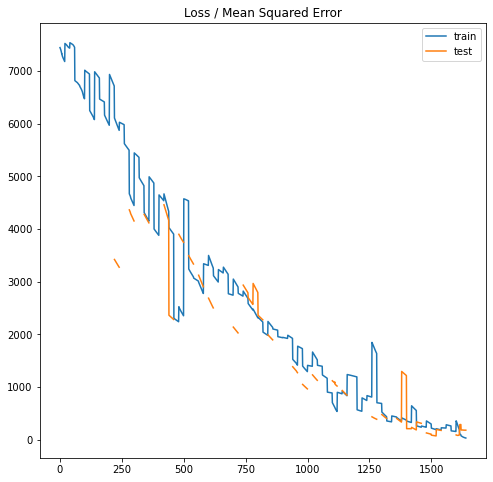

In [13]:
pyplot.figure(figsize=(8,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(hist_df['loss'], label='train')
pyplot.plot(hist_df['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [14]:
test

<MapDataset shapes: ((None, 20, 2), (None, 1, 2)), types: (tf.float64, tf.float64)>

In [15]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4480      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________


In [16]:
window_length = 20

x_test = tf.keras.utils.timeseries_dataset_from_array(
dfs[0][:20], targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)

In [17]:
x_test

<BatchDataset shapes: (None, None, 2), types: tf.float64>

In [18]:
y_pred =lstm_model.predict(x_test)

In [19]:
y_pred

array([[-93.57047 ,  16.712831]], dtype=float32)

In [20]:
truth = val_df.iloc[21][0], val_df.iloc[21][1]
truth

(-91.14800000000002, 9.519)

In [21]:
lstm_model.save("model.h5")